# 1.0 DATA PREPARATION

In [56]:
import pandas as pd
import numpy as np
import plotnine as pn
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [57]:
pn.options.dpi = 300

In [58]:
cdnow_raw_df = pd.read_csv('../data/cdnow.csv', index_col=0)

In [59]:
cdnow_raw_df.head(3)

,customer_id,date,quantity,price
0,1,1997-01-01,1,11.77
1,2,1997-01-12,1,12.00
2,2,1997-01-12,5,77.00


In [60]:
cdnow_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69659 entries, 0 to 69658
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   customer_id  69659 non-null  int64  
 1   date         69659 non-null  object 
 2   quantity     69659 non-null  int64  
 3   price        69659 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 2.7+ MB


In [97]:
# Print the index range
customer_range = cdnow_raw_df.customer_id.min(), cdnow_raw_df.customer_id.max()
print(f"Customer range: {customer_range}")

Customer range: (1, 23570)


In [61]:
# convert to datetime
cdnow_df = (
    cdnow_raw_df
    .assign(date=lambda x: pd.to_datetime(x['date']))
)

In [62]:
cdnow_df['date'].dtype

dtype('<M8[ns]')

# 2.0 COHORT ANALYSIS

In [63]:
# Extract just the date part without time
min_date = cdnow_df['date'].min().date()
max_date = cdnow_df['date'].max().date()

# Print the range of dates
print(f"Data ranges from {min_date} to {max_date}")

Data ranges from 1997-01-01 to 1998-06-30


## Get Range of Initial Purchases

In [64]:
cdnow_first_purchase_tbl = (
    cdnow_df
    .sort_values(['customer_id','date'])
    .groupby('customer_id')
    .first()
                            )

In [65]:
cdnow_first_purchase_tbl.head()

,date,quantity,price
customer_id,,,
1,1997-01-01,1,11.77
2,1997-01-12,1,12.00
3,1997-01-02,2,20.76
4,1997-01-01,2,29.33
5,1997-01-01,2,29.33


In [66]:
# Extract just the date part without time
min_date = cdnow_first_purchase_tbl['date'].min().date()
max_date = cdnow_first_purchase_tbl['date'].max().date()

# Print the range of dates
print(f"Dates range of initial purchases from {min_date} to {max_date}")

Dates range of initial purchases from 1997-01-01 to 1997-03-25


Despite containing a year and a half of data, all customers were acquired between 1/1997 and 3/1997.

## Visualize: All purchases within cohort

<Axes: xlabel='date'>

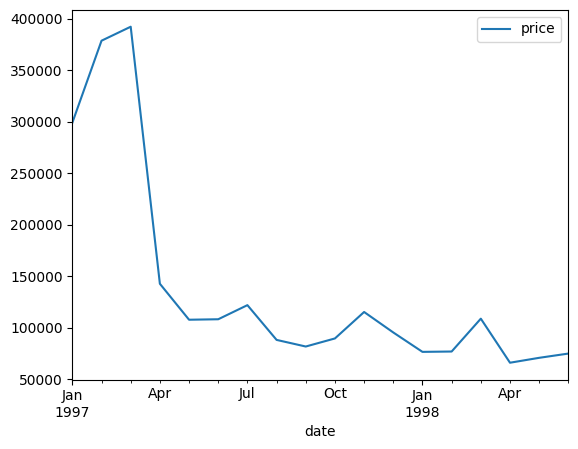

In [67]:
cdnow_df.reset_index() \
    .set_index('date') \
    [['price']] \
    .resample(rule='MS') \
    .sum() \
    .plot()

## Visualize: Individual Customer Purchases

In [68]:
# Select a subset of customer IDs
ids = cdnow_df['customer_id'].unique()
ids_selected = ids[:12]

/tmp/ipykernel_763919/2476615928.py:26: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().
/home/blackitalian/miniconda3/envs/cdnow/lib/python3.11/site-packages/plotnine/geoms/geom_path.py:113: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
/home/blackitalian/miniconda3/envs/cdnow/lib/python3.11/site-packages/plotnine/geoms/geom_path.py:113: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
/home/blackitalian/miniconda3/envs/cdnow/lib/python3.11/site-packages/plotnine/geoms/geom_path.py:113: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
/home/blackitalian/miniconda3/envs/cdnow/lib/python3.11/site-packages/plotnine/geoms/geom_path.py:113: PlotnineWarning: geom_path: Each group consist of only one observ

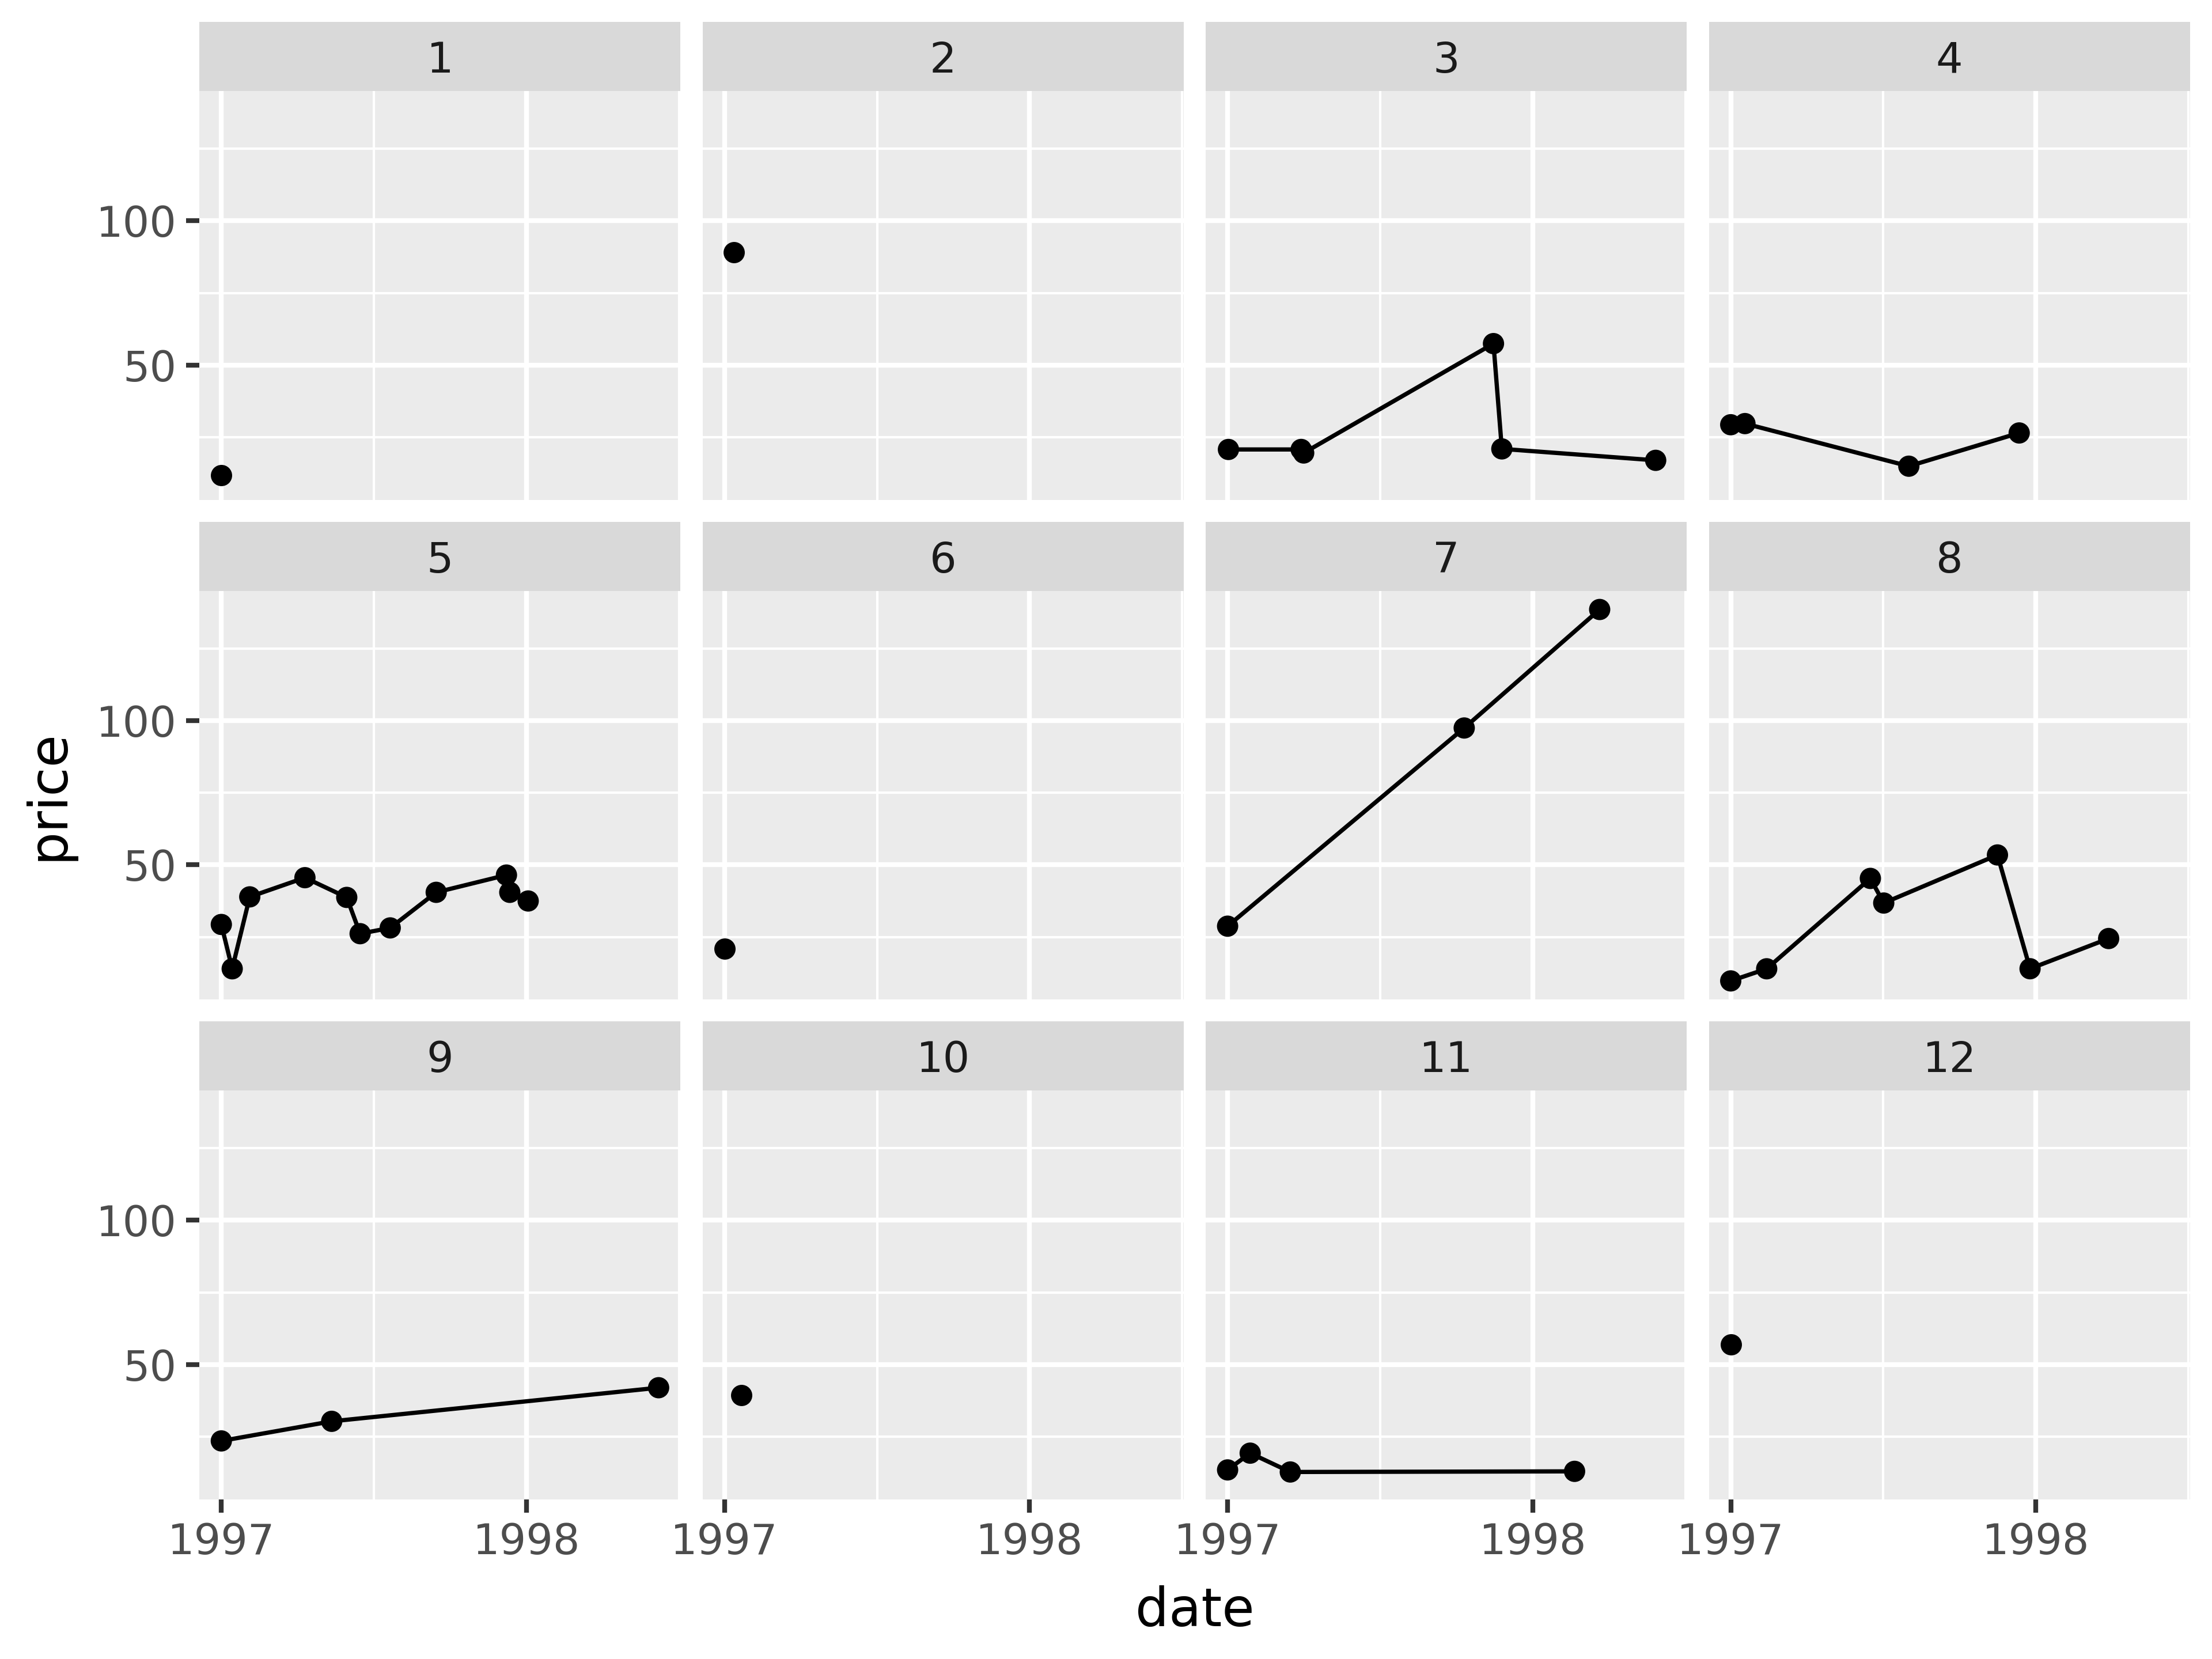

In [69]:
# ggplot API
# Filter the DataFrame for the selected customer IDs
cdnow_cust_id_subset_df = (
    cdnow_df[cdnow_df['customer_id'].isin(ids_selected)]
    .groupby(['customer_id', 'date'])
    .sum()
    .reset_index()
)

# Create the plot
plot = (
    pn.ggplot(
        cdnow_cust_id_subset_df,
        pn.aes('date', 'price', group='customer_id')
    )
    + pn.geom_line()
    + pn.geom_point()
    + pn.facet_wrap('~customer_id')
    + pn.scale_x_date(
        date_breaks='1 year',
        date_labels='%Y'
    )
)

# Display the plot
print(plot)

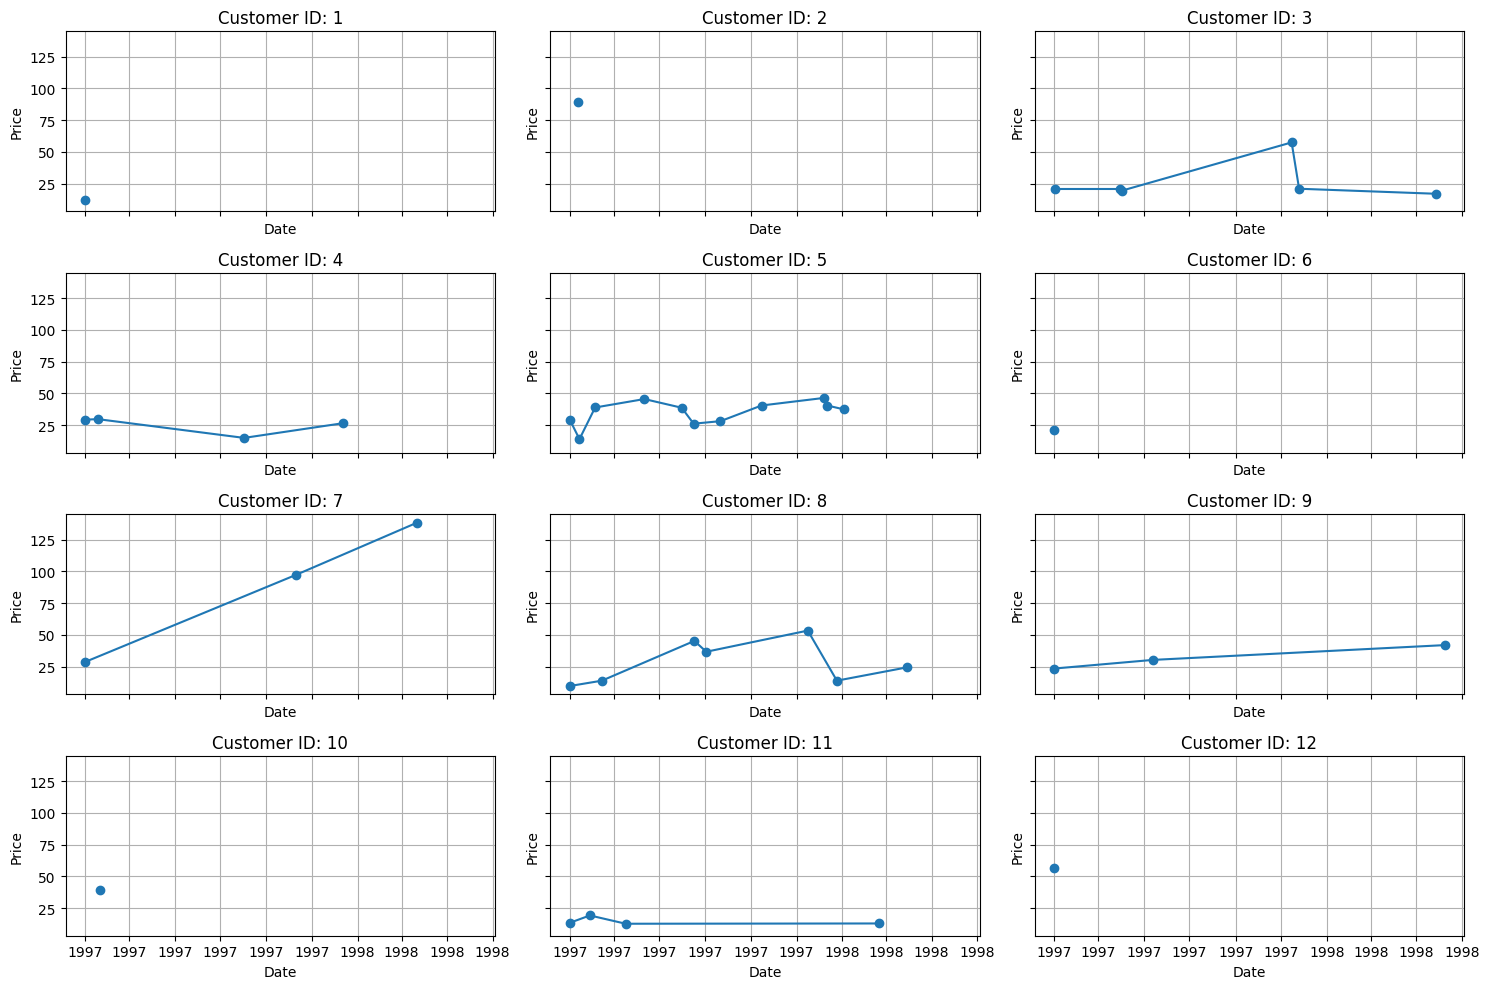

In [70]:
# Number of unique customers in the subset
unique_customers = cdnow_cust_id_subset_df['customer_id'].nunique()

# Define the number of rows and columns for the subplots
num_cols = 3
num_rows = (unique_customers + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10), sharex=True, sharey=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

for ax, (customer_id, group) in zip(axes, cdnow_cust_id_subset_df.groupby('customer_id')):
    ax.plot(group['date'], group['price'], marker='o', linestyle='-')
    ax.set_title(f'Customer ID: {customer_id}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))
    ax.grid(True) 

# Remove any empty subplots
for i in range(unique_customers, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()



# 3.0 FEATURE ENGINEERING

Frame problem:

- What will the customers spend in the next 90-days? (Regression)
- What is the probability of a customer to make a purchase in the next 90-days? (Classification)

## 3.1 TIME SPLITTING

In [71]:
n_days = 90
max_date = cdnow_df['date'].max()

# Calculate the cutoff date (90 days before end of data)
cutoff = max_date - pd.to_timedelta(n_days, unit='d')

In [72]:
temporal_in_df = cdnow_df[cdnow_df['date'] <= cutoff]
temporal_out_df = cdnow_df[cdnow_df['date'] > cutoff]

In [73]:
# Extract the minimum and maximum dates
min_date = temporal_in_df['date'].min().date()
max_date = temporal_in_df['date'].max().date()

# Print the range of dates
print(f"Dates range of temporal_in_df from {min_date} to {max_date}")

Dates range of temporal_in_df from 1997-01-01 to 1998-04-01


In [74]:
# Extract the minimum and maximum dates
min_date = temporal_out_df['date'].min().date()
max_date = temporal_out_df['date'].max().date()

# Print the range of dates
print(f"Dates range of temporal_out_df from {min_date} to {max_date}")

Dates range of temporal_out_df from 1998-04-02 to 1998-06-30


## 3.2 FEATURE ENGINEERING (RFM)

### Make Targets From Data

In [75]:
# flag for all data in the last 90 days
targets_df = (
    temporal_out_df
    .drop(['quantity','date'], axis=1) # must drop date to .sum()
    .groupby('customer_id')
    .sum()
    .rename({'price': 'spend_90_total'}, axis=1)
    .assign(spend_90_flag=1)  # Add a new column 'spend_90_flag' with value 1
)

In [76]:
targets_df.head(3)

,spend_90_total,spend_90_flag
customer_id,,
3,16.99,1
9,41.98,1
25,73.43,1


In [77]:
# From almost 70k down to 3301
targets_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3301 entries, 3 to 23561
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   spend_90_total  3301 non-null   float64
 1   spend_90_flag   3301 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 77.4 KB


### Make Recency (Date) Features From 'in' Data

In [78]:
max_date = temporal_in_df['date'].max()

In [79]:
# show the date diff from the last date
recency_features_df = (
    temporal_in_df
    #.drop(['quantity','price'], axis=1) <- not necessary
    [['customer_id','date']]
    .groupby('customer_id')
    .apply(lambda x: (x['date'].max() - max_date).days, include_groups=False)
    .to_frame(name='recency') # <- changes customer_id column to become index
    .set_axis(['recency'], axis=1)
)

In [80]:
recency_features_df.head(3)

,recency
customer_id,
1,-455
2,-444
3,-127


In [81]:
recency_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23570 entries, 1 to 23570
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   recency  23570 non-null  int64
dtypes: int64(1)
memory usage: 368.3 KB


### Make Frequency (Count) Features From 'in' Data

In [82]:
# how frequent customers are making purchases
frequency_features_df = (
    temporal_in_df[['customer_id','date']]
    .groupby('customer_id')
    .count()
    .set_axis(['frequency'], axis=1)
)

In [83]:
frequency_features_df.head()

,frequency
customer_id,
1,1
2,2
3,5
4,4
5,11


In [84]:
frequency_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23570 entries, 1 to 23570
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   frequency  23570 non-null  int64
dtypes: int64(1)
memory usage: 368.3 KB


### Make Price (Monetary) Features From 'in' Data

In [85]:
# Add total and average spend
price_features_df = (
    temporal_in_df
    .groupby('customer_id')
    .aggregate({'price':['sum','mean']})
    .set_axis(['price_sum','price_mean'], axis=1)
)

In [86]:
price_features_df.head(3)

,price_sum,price_mean
customer_id,,
1,11.77,11.770
2,89.00,44.500
3,139.47,27.894


In [87]:
price_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23570 entries, 1 to 23570
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   price_sum   23570 non-null  float64
 1   price_mean  23570 non-null  float64
dtypes: float64(2)
memory usage: 552.4 KB


### 3.3 Combine Features

In [88]:
features_df = (
    pd.concat(
        [recency_features_df,frequency_features_df,price_features_df],axis=1
    )
    .merge(
        targets_df,
        left_index=True,
        right_index=True,
        how='left'
    )
    .fillna(0) # Customers that did not make a purchase show as NaN otherwise
)

In [89]:
features_df.head(3)

,recency,frequency,price_sum,price_mean,spend_90_total,spend_90_flag
customer_id,,,,,,
1,-455,1,11.77,11.770,0.00,0.0
2,-444,2,89.00,44.500,0.00,0.0
3,-127,5,139.47,27.894,16.99,1.0


In [90]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23570 entries, 1 to 23570
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   recency         23570 non-null  int64  
 1   frequency       23570 non-null  int64  
 2   price_sum       23570 non-null  float64
 3   price_mean      23570 non-null  float64
 4   spend_90_total  23570 non-null  float64
 5   spend_90_flag   23570 non-null  float64
dtypes: float64(4), int64(2)
memory usage: 1.3 MB


In [93]:
# Print the index range
index_range = features_df.index.min(), features_df.index.max()
print(f"Index range: {index_range}")

Index range: (1, 23570)


In [98]:
features_df.spend_90_flag.value_counts()

spend_90_flag
0.0    20269
1.0     3301
Name: count, dtype: int64

The 90 flag class is highly imbalanced.

In [92]:
features_df.to_pickle('../artifacts/features_df.pkl')

# 4.0 MACHINE LEARNING

## Imports

## 4.1 Next 90-Day Spend Prediction (Regression)

In [ ]:
# import cudf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_predict, learning_curve
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report, roc_auc_score
from xgboost import XGBRegressor, XGBClassifier, plot_importance
from catboost import CatBoostRegressor, CatBoostClassifier
import joblib

In [ ]:
# !nvidia-smi

In [ ]:
# Data prep
features_df = pd.read_pickle('../artifacts/features_df.pkl')
# features_df = cudf.DataFrame.from_pandas(pandas_df)
y_reg = features_df['spend_90_total']
X = features_df[['recency', 'frequency', 'price_sum', 'price_mean']]
# params
cv = 10
n_jobs = -1
random_seed=42

In [ ]:
# Define the XGBRegressor with hyperparameters
xgb_reg_spec = XGBRegressor(
    objective='reg:squarederror',
        random_state=random_seed
    # tree_method='hist', # gpu_hist depreciated
    # device='cuda', # now use this
    # gpu_id=0
)

xgb_reg_param_grid = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5],
    'alpha': [0, 0.1, 0.5, 1],  # L1 regularization term on weights
    'lambda': [1, 1.5, 2, 3]   # L2 regularization term on weights
}

# Grid search for XGBRegressor
xgb_reg_grid_search = GridSearchCV(
    estimator=xgb_reg_spec,
    param_grid=xgb_reg_param_grid,
    scoring='neg_mean_absolute_error',
    refit=True,
    cv=cv,
    n_jobs=n_jobs
)

In [ ]:
# Define the CatBoostRegressor with hyperparameters
cat_reg_spec = CatBoostRegressor(
    loss_function='MAE',
    # task_type='GPU',
    random_seed=random_seed,
    verbose=0 
)

cat_reg_param_grid = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'depth': [3, 4, 5, 6],
    'iterations': [100, 200, 300],
    'l2_leaf_reg': [1, 3, 5, 7]
}

# Grid search for CatBoostRegressor
cat_reg_grid_search = GridSearchCV(
    estimator=cat_reg_spec,
    param_grid=cat_reg_param_grid,
    scoring='neg_mean_absolute_error',
    refit=True,
     cv=cv,
    n_jobs=n_jobs
)

In [ ]:
# Fit the model using the training data
xgb_reg_grid_search.fit(X, y_reg)
cat_reg_grid_search.fit(X, y_reg)

In [ ]:
# Get the best models
best_xgb_reg_model = xgb_reg_grid_search.best_estimator_
best_cat_reg_model = cat_reg_grid_search.best_estimator_

# Save the best models to disk
joblib.dump(best_xgb_reg_model, '../models/best_xgb_reg_model.pkl')
joblib.dump(best_cat_reg_model, '../models/best_cat_reg_model.pkl')

In [ ]:
# Generate predictions using cross-validation
xgb_reg_predictions = cross_val_predict(best_xgb_reg_model, X, y_reg, cv=cv)
cat_reg_predictions = cross_val_predict(best_cat_reg_model, X, y_reg, cv=cv)

# Save predictions
joblib.dump(xgb_reg_predictions, '../artifacts/xgb_reg_predictions.pkl')
joblib.dump(cat_reg_predictions, '../artifacts/cat_reg_predictions.pkl')

In [ ]:
# Debugging: Check types and shapes
print(f"xgb_reg_predictions type: {type(xgb_reg_predictions)}, shape: {xgb_reg_predictions.shape}")
print(f"cat_reg_predictions type: {type(cat_reg_predictions)}, shape: {cat_reg_predictions.shape}")
print(f"y_reg type: {type(y_reg)}, shape: {y_reg.shape}")

In [ ]:
# Ensure the data types and lengths match
print(f"Length of xgb_reg_predictions: {len(xgb_reg_predictions)}")
print(f"Length of cat_reg_predictions: {len(cat_reg_predictions)}")
print(f"Length of y_reg: {len(y_reg)}")

In [ ]:
assert len(xgb_reg_predictions) == len(y_reg), "Length of XGB predictions and true values do not match."
assert len(cat_reg_predictions) == len(y_reg), "Length of CatBoost predictions and true values do not match."

### Regression Interpretation

In [ ]:
# To load the models back
best_xgb_reg_model = joblib.load('../artifacts/best_xgb_reg_model.pkl')
best_cat_reg_model = joblib.load('../artifacts/best_cat_reg_model.pkl')

In [ ]:
# Load Predictions
xgb_reg_predictions = joblib.load('../artifacts/xgb_reg_predictions.pkl')
cat_reg_predictions = joblib.load('../artifacts/cat_reg_predictions.pkl')

In [ ]:
# load features and set y_reg
features_df = joblib.load('../artifacts/features_df.pkl')
y_reg = features_df['spend_90_total']

In [ ]:
# Evaluation function
def evaluate_model(predictions, true_values):
    mae = mean_absolute_error(true_values, predictions)
    mse = mean_squared_error(true_values, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(true_values, predictions)
    return mae, mse, rmse, r2

In [ ]:
# Evaluate models
xgb_mae, xgb_mse, xgb_rmse, xgb_r2 = evaluate_model(xgb_reg_predictions, y_reg)
cat_mae, cat_mse, cat_rmse, cat_r2 = evaluate_model(cat_reg_predictions, y_reg)

print("XGBRegressor:")
print(f"MAE: {xgb_mae:.4f}, MSE: {xgb_mse:.4f}, RMSE: {xgb_rmse:.4f}, R²: {xgb_r2:.4f}")
print("CatBoostRegressor:")
print(f"MAE: {cat_mae:.4f}, MSE: {cat_mse:.4f}, RMSE: {cat_rmse:.4f}, R²: {cat_r2:.4f}")

In [ ]:
# Residual plots
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.residplot(x=xgb_reg_predictions, y=y_reg - xgb_reg_predictions, lowess=True, color='blue', line_kws={'color': 'red'})
plt.title('XGBRegressor Residuals')
plt.xlabel('Predicted')
plt.ylabel('Residuals')

plt.subplot(1, 2, 2)
sns.residplot(x=cat_reg_predictions, y=y_reg - cat_reg_predictions, lowess=True, color='green', line_kws={'color': 'red'})
plt.title('CatBoostRegressor Residuals')
plt.xlabel('Predicted')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()

In [ ]:
# Actual vs Predicted plots
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_reg, xgb_reg_predictions, alpha=0.3, color='blue')
plt.plot([y_reg.min(), y_reg.max()], [y_reg.min(), y_reg.max()], 'r--')
plt.title('XGBRegressor: Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')

plt.subplot(1, 2, 2)
plt.scatter(y_reg, cat_reg_predictions, alpha=0.3, color='green')
plt.plot([y_reg.min(), y_reg.max()], [y_reg.min(), y_reg.max()], 'r--')
plt.title('CatBoostRegressor: Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')

plt.tight_layout()
plt.show()

In [ ]:
# Plot feature importance for XGBoost
plt.figure(figsize=(10, 6))
plot_importance(best_xgb_reg_model, importance_type='weight')
plt.title('XGBoost Feature Importance')
plt.show()

# Plot feature importance for CatBoost
plt.figure(figsize=(10, 6))
cat_importance = best_cat_reg_model.get_feature_importance(prettified=True)
sns.barplot(x='Importances', y='Feature Id', data=cat_importance)
plt.title('CatBoost Feature Importance')
plt.show()

In [ ]:
def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='neg_mean_absolute_error')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Plot learning curves
plot_learning_curve(best_xgb_reg_model, 'XGBoost Learning Curve', X, y_reg, cv=cv, n_jobs=n_jobs)
plot_learning_curve(best_cat_reg_model, 'CatBoost Learning Curve', X, y_reg, cv=cv, n_jobs=n_jobs)
plt.show()

XGBRegressor:
* MAE: 10.5976
* MSE: 1024.4278
* RMSE: 32.0067
* R²: 0.4625

CatBoostRegressor:
* MAE: 8.0699
* MSE: 1288.0488
* RMSE: 35.8894
* R²: 0.3242

Comparison:
1. Mean Absolute Error (MAE):
    * CatBoostRegressor has a lower MAE (8.0699) compared to XGBRegressor (10.5976), indicating that CatBoost has, on average, smaller absolute errors.
1. Mean Squared Error (MSE):
    * XGBRegressor has a lower MSE (1024.4278) compared to CatBoostRegressor (1288.0488), indicating that XGB has smaller squared errors overall.
1. Root Mean Squared Error (RMSE):
    *XGBRegressor has a lower RMSE (32.0067) compared to CatBoostRegressor (35.8894), indicating that XGB has fewer large errors compared to CatBoost.
1. R² (R-squared):
    * XGBRegressor has a higher R² (0.4625) compared to CatBoostRegressor (0.3242), indicating that XGB explains more of the variance in the target variable.

Conclusion:

MAE suggests that CatBoost has better average prediction accuracy.
MSE and RMSE suggest that XGBoost handles large errors better than CatBoost.
R² indicates that XGBoost explains more variance in the data than CatBoost.
Given these metrics, XGBRegressor seems to be the better-performing model overall, especially considering its ability to handle large errors and explain variance in the target variable. 

## 4.2 XGBoost Regression Parameter Tuning

Bayesian Optimization

In [ ]:
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import joblib
import numpy as np
import pandas as pd

In [ ]:
# Data prep
features_df = pd.read_pickle('../artifacts/features_df.pkl')
# features_df = cudf.DataFrame.from_pandas(pandas_df)
y_reg = features_df['spend_90_total']
X = features_df[['recency', 'frequency', 'price_sum', 'price_mean']]
# params
cv = 10
n_jobs = -1
random_seed=42

In [ ]:
def xgb_evaluate(max_depth, gamma, subsample, colsample_bytree, learning_rate, alpha, lambda_, min_child_weight, scale_pos_weight):
    params = {
        'max_depth': int(max_depth),
        'gamma': gamma,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'learning_rate': learning_rate,
        'n_estimators': 100,
        'min_child_weight': min_child_weight,
        'alpha': alpha,
        'lambda': lambda_,
        'scale_pos_weight': scale_pos_weight,
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse'
    }
    xgb_model = XGBRegressor(**params)
    cv_result = cross_val_score(xgb_model, X, y_reg, cv=10, scoring='neg_mean_absolute_error')
    return np.mean(cv_result)

# Set the parameter bounds
param_bounds = {
    'max_depth': (3, 10),
    'gamma': (0, 0.5),
    'subsample': (0.6, 1.0),
    'colsample_bytree': (0.6, 1.0),
    'learning_rate': (0.01, 0.3),
    'alpha': (0, 1),
    'lambda_': (1, 3),
    'min_child_weight': (1, 10),
    'scale_pos_weight': (1, 3)
}

# Initialize Bayesian Optimization
optimizer = BayesianOptimization(f=xgb_evaluate, pbounds=param_bounds, random_state=42)

# Optimize
optimizer.maximize(init_points=10, n_iter=50)

# Get the best parameters
best_params_bayes = optimizer.max['params']
best_params_bayes['max_depth'] = int(best_params_bayes['max_depth'])  # convert max_depth to int
print(f"Best parameters found by Bayesian Optimization: {best_params_bayes}")

# Fit the model with the best parameters
best_xgb_model_bayes = XGBRegressor(**best_params_bayes, objective='reg:squarederror', n_estimators=100)
best_xgb_model_bayes.fit(X, y_reg)

# Save the best model
joblib.dump(best_xgb_model_bayes, '../models/best_xgb_reg_model_bayes_tuned.pkl')

# Generate predictions using cross-validation
xgb_reg_predictions_bayes_tuned = cross_val_predict(best_xgb_model_bayes, X, y_reg, cv=10)

# Save the predictions
joblib.dump(xgb_reg_predictions_bayes_tuned, '../artifacts/xgb_reg_predictions_bayes_tuned.pkl')


In [ ]:
# Evaluation function
def evaluate_model(predictions, true_values):
    mae = mean_absolute_error(true_values, predictions)
    mse = mean_squared_error(true_values, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(true_values, predictions)
    return mae, mse, rmse, r2

# Evaluate the tuned model
xgb_mae_bayes_tuned, xgb_mse_bayes_tuned, xgb_rmse_bayes_tuned, xgb_r2_bayes_tuned = evaluate_model(xgb_reg_predictions_bayes_tuned, y_reg)

print("Bayesian Tuned XGBRegressor:")
print(f"MAE: {xgb_mae_bayes_tuned:.4f}, MSE: {xgb_mse_bayes_tuned:.4f}, RMSE: {xgb_rmse_bayes_tuned:.4f}, R²: {xgb_r2_bayes_tuned:.4f}")

### RandomizedSearchCV for thorough hyperparameter tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 4, 5, 6, 8],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'alpha': [0, 0.1, 0.5, 1],
    'lambda': [1, 1.5, 2, 3],
    'scale_pos_weight': [1, 1.5, 2, 3]
}

# Initialize the XGBRegressor
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid, n_iter=100, 
                                   scoring='neg_mean_absolute_error', cv=10, verbose=1, random_state=42, n_jobs=-1)

# Fit the model
random_search.fit(X, y_reg)

# Get the best model
best_xgb_model_random = random_search.best_estimator_

# Save the best model
joblib.dump(best_xgb_model_random, '../models/best_xgb_reg_model_random_tuned.pkl')

# Generate predictions using cross-validation
xgb_reg_predictions_random_tuned = cross_val_predict(best_xgb_model_random, X, y_reg, cv=10)

# Save the predictions
joblib.dump(xgb_reg_predictions_random_tuned, '../artifacts/xgb_reg_predictions_random_tuned.pkl')


In [ ]:
# Evaluate the tuned model
xgb_mae_random_tuned, xgb_mse_random_tuned, xgb_rmse_random_tuned, xgb_r2_random_tuned = evaluate_model(xgb_reg_predictions_random_tuned, y_reg)

print("Randomized Search Tuned XGBRegressor:")
print(f"MAE: {xgb_mae_random_tuned:.4f}, MSE: {xgb_mse_random_tuned:.4f}, RMSE: {xgb_rmse_random_tuned:.4f}, R²: {xgb_r2_random_tuned:.4f}")

Neither of the two models out perform the initial XGBoost model.

## 4.3 Ensemble

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import joblib

In [ ]:
# Data prep
features_df = pd.read_pickle('../artifacts/features_df.pkl')
# features_df = cudf.DataFrame.from_pandas(pandas_df)
y_reg = features_df['spend_90_total']
X = features_df[['recency', 'frequency', 'price_sum', 'price_mean']]

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_reg, test_size=0.2, random_state=42)

# Initialize base models with hyperparameter tuning
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
catboost_model = CatBoostRegressor(loss_function='MAE', random_seed=42, verbose=0)

# Define hyperparameters for grid search
xgb_param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300]
}

catboost_param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [3, 5, 7],
    'iterations': [100, 200, 300]
}

# Perform grid search for each model
xgb_grid_search = GridSearchCV(estimator=xgb_model, param_grid=xgb_param_grid, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
catboost_grid_search = GridSearchCV(estimator=catboost_model, param_grid=catboost_param_grid, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

# Fit grid search
xgb_grid_search.fit(X_train, y_train)
catboost_grid_search.fit(X_train, y_train)

# Get best models
best_xgb_model = xgb_grid_search.best_estimator_
best_catboost_model = catboost_grid_search.best_estimator_

# Initialize stacking model with a ridge regression meta-model
stacking_model = StackingRegressor(
    estimators=[
        ('xgb', best_xgb_model),
        ('catboost', best_catboost_model)
    ],
    final_estimator=Ridge(alpha=1.0),
    cv=5
)

# Fit the stacking model
stacking_model.fit(X_train, y_train)

# Save the stacking model
joblib.dump(stacking_model, '../models/stacking_model_tuned.pkl')

# Predict on the test set
y_pred_test = stacking_model.predict(X_test)

In [ ]:
# Evaluate model
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, r2

test_mae, test_mse, test_rmse, test_r2 = evaluate_model(y_test, y_pred_test)

print("Tuned Stacking Model Test Metrics:")
print(f"MAE: {test_mae:.4f}, MSE: {test_mse:.4f}, RMSE: {test_rmse:.4f}, R²: {test_r2:.4f}")

In [ ]:
# Predict and evaluate on the training set (optional, to check for overfitting)
y_pred_train = stacking_model.predict(X_train)
train_mae, train_mse, train_rmse, train_r2 = evaluate_model(y_train, y_pred_train)

print("Tuned Stacking Model Train Metrics:")
print(f"MAE: {train_mae:.4f}, MSE: {train_mse:.4f}, RMSE: {train_rmse:.4f}, R²: {train_r2:.4f}")

#### Ensemble 2

In [ ]:
best_xgb_reg_model = joblib.load('../models/best_xgb_reg_model.pkl')
stacking_model = joblib.load('../models/stacking_model_tuned.pkl')

In [ ]:
# Combining predictions from both models
xgb_predictions = best_xgb_reg_model.predict(X_test)
stacking_predictions = stacking_model.predict(X_test)

# Weighted average of predictions
combined_predictions = (xgb_predictions + stacking_predictions) / 2

# Evaluate combined model
combined_mae, combined_mse, combined_rmse, combined_r2 = evaluate_model(y_test, combined_predictions)

print("Combined Model Test Metrics:")
print(f"MAE: {combined_mae:.4f}, MSE: {combined_mse:.4f}, RMSE: {combined_rmse:.4f}, R²: {combined_r2:.4f}")

## 4.4 Final Regression Model

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

# Data preparation
features_df = pd.read_pickle('../artifacts/features_df.pkl')
y_reg = features_df['spend_90_total']
X = features_df[['recency', 'frequency', 'price_sum', 'price_mean']]

# Load the best models
best_xgb_reg_model = joblib.load('../models/best_xgb_reg_model.pkl')
stacking_model = joblib.load('../models/stacking_model.pkl')

# Combine predictions from both models
xgb_predictions = best_xgb_reg_model.predict(X)
stacking_predictions = stacking_model.predict(X)
combined_predictions = (xgb_predictions + stacking_predictions) / 2

# Save combined predictions to a separate file
combined_reg_predictions_df = pd.DataFrame({'combined_predictions': combined_predictions})
combined_reg_predictions_df.to_pickle('../artifacts/combined_reg_predictions_final.pkl')

# Evaluate combined model
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, r2

combined_mae, combined_mse, combined_rmse, combined_r2 = evaluate_model(y_reg, combined_predictions)

print("Combined Model Metrics on All Data:")
print(f"MAE: {combined_mae:.4f}, MSE: {combined_mse:.4f}, RMSE: {combined_rmse:.4f}, R²: {combined_r2:.4f}")


#### Feature Importance

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import plot_importance
import joblib

In [ ]:
# Load the best XGBoost model
best_xgb_reg_model = joblib.load('../models/best_xgb_reg_model.pkl')

# Plot feature importance for the XGBoost model
plt.figure(figsize=(10, 6))
plot_importance(best_xgb_reg_model, importance_type='weight')
plt.title('XGBoost Feature Importance')
plt.show()

In [ ]:
# Load the stacking model
stacking_model = joblib.load('../models/stacking_model.pkl')

# Assuming the stacking model uses XGBoost and CatBoost as base models
xgb_model = stacking_model.named_estimators_['xgb']
catboost_model = stacking_model.named_estimators_['catboost']

# Plot feature importance for the XGBoost base model in the stacking model
plt.figure(figsize=(10, 6))
plot_importance(xgb_model, importance_type='weight')
plt.title('XGBoost Base Model Feature Importance in Stacking')
plt.show()

# Plot feature importance for the CatBoost base model
# CatBoost doesn't have a direct plot_importance function, so we extract and plot manually
feature_importances = catboost_model.get_feature_importance()
features = ['recency', 'frequency', 'price_sum', 'price_mean']  # Replace with actual feature names
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

plt.figure(figsize=(10, 6))
importance_df.sort_values(by='Importance', ascending=False).plot(kind='bar', x='Feature', y='Importance', legend=False)
plt.title('CatBoost Base Model Feature Importance in Stacking')
plt.show()

#### Final Regression Assessment

Given the metrics, the Combined Model on all data demonstrates superior performance in terms of prediction accuracy (MAE, MSE, RMSE) compared to both the previous ensemble models on the test set and the original XGBoost model. Despite having a slightly lower R² than the previous best combined model on the test set, its overall performance is robust and indicates that it is the best performing model.

## 4.5 Next 90-Day Spend Probability (Binary Classification)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import joblib
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [ ]:
features_df = pd.read_pickle('../artifacts/features_df.pkl')
X = features_df[['recency','frequency','price_sum','price_mean']]
y_class = features_df['spend_90_flag']

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=42)

In [ ]:
# Define the XGBClassifier with hyperparameters
xgb_class_spec = XGBClassifier(
    objective='binary:logistic',
    random_state=42
)

xgb_class_param_grid = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5],
    'alpha': [0, 0.1, 0.5, 1],
    'lambda': [1, 1.5, 2, 3]
}

# Grid search for XGBClassifier
xgb_class_grid_search = GridSearchCV(
    estimator=xgb_class_spec,
    param_grid=xgb_class_param_grid,
    scoring='roc_auc',
    refit=True,
    cv=5,
    n_jobs=-1
)

# Fit the XGBClassifier grid search
xgb_class_grid_search.fit(X_train, y_train)
best_xgb_class_model = xgb_class_grid_search.best_estimator_

# Save the best XGBClassifier model
joblib.dump(best_xgb_class_model, '../models/best_xgb_class_model_final.pkl')

In [ ]:
# Define the CatBoostClassifier with hyperparameters
cat_class_spec = CatBoostClassifier(
    loss_function='Logloss',
    random_seed=42,
    verbose=0
)

cat_class_param_grid = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'depth': [3, 4, 5, 6],
    'iterations': [100, 200, 300],
    'l2_leaf_reg': [1, 3, 5, 7]
}

# Grid search for CatBoostClassifier
cat_class_grid_search = GridSearchCV(
    estimator=cat_class_spec,
    param_grid=cat_class_param_grid,
    scoring='roc_auc',
    refit=True,
    cv=5,
    n_jobs=6
)

# Fit the CatBoostClassifier grid search
cat_class_grid_search.fit(X_train, y_train)
best_cat_class_model = cat_class_grid_search.best_estimator_

# Save the best CatBoostClassifier model
joblib.dump(best_cat_class_model, '../models/best_cat_class_model_final.pkl')

In [ ]:
xgb_y_pred = best_xgb_class_model.predict(X_test)
xgb_y_pred_proba = best_xgb_class_model.predict_proba(X_test)[:, 1]
xgb_accuracy = accuracy_score(y_test, xgb_y_pred)
xgb_precision = precision_score(y_test, xgb_y_pred)
xgb_recall = recall_score(y_test, xgb_y_pred)
xgb_f1 = f1_score(y_test, xgb_y_pred)
xgb_roc_auc = roc_auc_score(y_test, xgb_y_pred_proba)

# Predict and evaluate CatBoost Classifier
catboost_y_pred = best_cat_class_model.predict(X_test)
catboost_y_pred_proba = best_cat_class_model.predict_proba(X_test)[:, 1]
catboost_accuracy = accuracy_score(y_test, catboost_y_pred)
catboost_precision = precision_score(y_test, catboost_y_pred)
catboost_recall = recall_score(y_test, catboost_y_pred)
catboost_f1 = f1_score(y_test, catboost_y_pred)
catboost_roc_auc = roc_auc_score(y_test, catboost_y_pred_proba)

# Print evaluation metrics
print("XGBoost Classifier Metrics:")
print(f"Accuracy: {xgb_accuracy:.4f}")
print(f"Precision: {xgb_precision:.4f}")
print(f"Recall: {xgb_recall:.4f}")
print(f"F1 Score: {xgb_f1:.4f}")
print(f"ROC-AUC: {xgb_roc_auc:.4f}")

print("\nCatBoost Classifier Metrics:")
print(f"Accuracy: {catboost_accuracy:.4f}")
print(f"Precision: {catboost_precision:.4f}")
print(f"Recall: {catboost_recall:.4f}")
print(f"F1 Score: {catboost_f1:.4f}")
print(f"ROC-AUC: {catboost_roc_auc:.4f}")

In [ ]:
# Plot ROC Curve
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_y_pred_proba)
fpr_catboost, tpr_catboost, _ = roc_curve(y_test, catboost_y_pred_proba)

plt.figure(figsize=(10, 6))
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {xgb_roc_auc:.4f})')
plt.plot(fpr_catboost, tpr_catboost, label=f'CatBoost (AUC = {catboost_roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

## 4.6 Catboost Classification Parameter Tuning

In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import joblib
from catboost import CatBoostClassifier

In [26]:
# Load data
features_df = pd.read_pickle('../artifacts/features_df.pkl')
X = features_df[['recency', 'frequency', 'price_sum', 'price_mean']]
y_class = features_df['spend_90_flag']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=42)

In [27]:
# Define the CatBoostClassifier with initial parameters
cat_class_spec = CatBoostClassifier(
    loss_function='Logloss',
    random_seed=42,
    verbose=0
)

# Define the hyperparameter grid for fine-tuning
cat_class_param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'depth': [4, 6, 8, 10],
    'iterations': [100, 200, 300, 500],
    'l2_leaf_reg': [1, 3, 5, 7, 9]
}

# Define the GridSearchCV object
cat_class_grid_search = GridSearchCV(
    estimator=cat_class_spec,
    param_grid=cat_class_param_grid,
    scoring='roc_auc',
    refit=True,
    cv=5,
    n_jobs=-1
)

# Fit the GridSearchCV object to find the best parameters
cat_class_grid_search.fit(X_train, y_train)
best_cat_class_model = cat_class_grid_search.best_estimator_

# Save the best CatBoostClassifier model
joblib.dump(best_cat_class_model, '../models/cat_class_model_tuning.pkl')

/home/blackitalian/miniconda3/envs/cdnow/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


['../models/cat_class_model_tuning.pkl']

In [28]:
# Predict and evaluate CatBoost Classifier with best parameters
catboost_y_pred = best_cat_class_model.predict(X_test)
catboost_y_pred_proba = best_cat_class_model.predict_proba(X_test)[:, 1]
catboost_accuracy = accuracy_score(y_test, catboost_y_pred)
catboost_precision = precision_score(y_test, catboost_y_pred)
catboost_recall = recall_score(y_test, catboost_y_pred)
catboost_f1 = f1_score(y_test, catboost_y_pred)
catboost_roc_auc = roc_auc_score(y_test, catboost_y_pred_proba)

# Print evaluation metrics
print("CatBoost Classifier Metrics (Tuned):")
print(f"Accuracy: {catboost_accuracy:.4f}")
print(f"Precision: {catboost_precision:.4f}")
print(f"Recall: {catboost_recall:.4f}")
print(f"F1 Score: {catboost_f1:.4f}")
print(f"ROC-AUC: {catboost_roc_auc:.4f}")

CatBoost Classifier Metrics (Tuned):
Accuracy: 0.8806
Precision: 0.6687
Recall: 0.3214
F1 Score: 0.4342
ROC-AUC: 0.8472


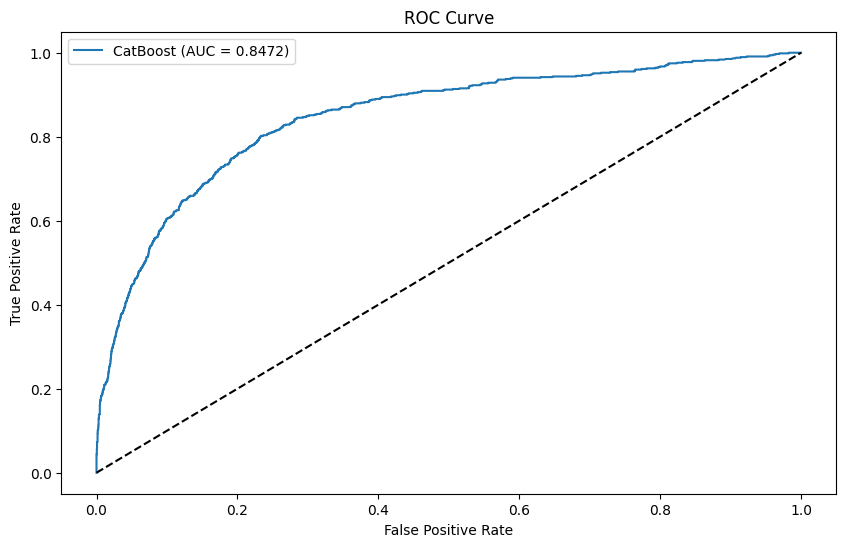

In [29]:
# Plot ROC Curve
fpr_catboost, tpr_catboost, _ = roc_curve(y_test, catboost_y_pred_proba)

plt.figure(figsize=(10, 6))
plt.plot(fpr_catboost, tpr_catboost, label=f'CatBoost (AUC = {catboost_roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

Overall Performance: The tuned CatBoost classifier demonstrates slight improvements in recall, F1 score, and ROC-AUC compared to the previous models. These improvements suggest that fine-tuning the CatBoost classifier has resulted in a better balance between identifying true positive cases and maintaining a low false positive rate

In [30]:
joblib.dump(best_cat_class_model, '../models/best_cat_class_model_final.pkl')

['../models/best_cat_class_model_final.pkl']

In [31]:
# Generate probabilities using the predict_proba method
combined_class_y_pred_final = best_cat_class_model.predict_proba(X)[:, 1]
# Save the probabilities as a NumPy array to a pickle file
joblib.dump(combined_class_y_pred_final, '../artifacts/combined_class_y_pred_final.pkl')

# Convert to DataFrame if needed
combined_class_y_pred_final_df = pd.DataFrame(combined_class_y_pred_final, columns=['pred_prob'])

# Save the probabilities to a pickle file
combined_class_y_pred_final_df.to_pickle('../artifacts/combined_class_y_pred_df_final.pkl')

## 4.7 Classification Ensemble

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import joblib
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [ ]:
# Load data
features_df = pd.read_pickle('../artifacts/features_df.pkl')
X = features_df[['recency', 'frequency', 'price_sum', 'price_mean']]
y_class = features_df['spend_90_flag']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=42)

In [ ]:
# Define the XGBClassifier with initial parameters
xgb_class_spec = XGBClassifier(
    objective='binary:logistic',
    random_state=42
)

xgb_class_param_grid = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5],
    'alpha': [0, 0.1, 0.5, 1],
    'lambda': [1, 1.5, 2, 3]
}

# Grid search for XGBClassifier
xgb_class_grid_search = GridSearchCV(
    estimator=xgb_class_spec,
    param_grid=xgb_class_param_grid,
    scoring='roc_auc',
    refit=True,
    cv=5,
    n_jobs=-1
)

# Fit the XGBClassifier grid search
xgb_class_grid_search.fit(X_train, y_train)
best_xgb_class_model = xgb_class_grid_search.best_estimator_

# Save the best XGBClassifier model
joblib.dump(best_xgb_class_model, '../models/best_xgb_class_model_final.pkl')

# Define the CatBoostClassifier with initial parameters
cat_class_spec = CatBoostClassifier(
    loss_function='Logloss',
    random_seed=42,
    verbose=0
)

cat_class_param_grid = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'depth': [4, 6, 8, 10],
    'iterations': [100, 200, 300, 500],
    'l2_leaf_reg': [1, 3, 5, 7, 9]
}

# Grid search for CatBoostClassifier
cat_class_grid_search = GridSearchCV(
    estimator=cat_class_spec,
    param_grid=cat_class_param_grid,
    scoring='roc_auc',
    refit=True,
    cv=5,
    n_jobs=-1
)

# Fit the CatBoostClassifier grid search
cat_class_grid_search.fit(X_train, y_train)
best_cat_class_model = cat_class_grid_search.best_estimator_

# Save the best CatBoostClassifier model
joblib.dump(best_cat_class_model, '../models/best_cat_class_model_final.pkl')

In [ ]:
# Predict and evaluate XGBoost Classifier with best parameters
xgb_y_pred_proba = best_xgb_class_model.predict_proba(X)[:, 1]

# Predict and evaluate CatBoost Classifier with best parameters
catboost_y_pred_proba = best_cat_class_model.predict_proba(X)[:, 1]

# Combine predictions using simple average
combined_pred_proba = (xgb_y_pred_proba + catboost_y_pred_proba) / 2
combined_y_pred = (combined_pred_proba >= 0.5).astype(int)

# Convert to DataFrame if necessary
combined_class_y_pred_df = pd.DataFrame({'combined_y_pred': combined_y_pred})

# Save combined predictions to a pickle file
combined_class_y_pred_df.to_pickle('../artifacts/combined_class_y_pred_final.pkl')


In [ ]:
# Combine predictions using simple average
combined_pred_proba = (xgb_y_pred_proba + catboost_y_pred_proba) / 2
combined_y_pred = (combined_pred_proba >= 0.5).astype(int)

# Evaluate combined model
combined_accuracy = accuracy_score(y_test, combined_y_pred)
combined_precision = precision_score(y_test, combined_y_pred)
combined_recall = recall_score(y_test, combined_y_pred)
combined_f1 = f1_score(y_test, combined_y_pred)
combined_roc_auc = roc_auc_score(y_test, combined_pred_proba)

print("Combined Model Metrics:")
print(f"Accuracy: {combined_accuracy:.4f}")
print(f"Precision: {combined_precision:.4f}")
print(f"Recall: {combined_recall:.4f}")
print(f"F1 Score: {combined_f1:.4f}")
print(f"ROC-AUC: {combined_roc_auc:.4f}")

In [ ]:
# Plot ROC Curve for combined model
fpr, tpr, _ = roc_curve(y_test, combined_pred_proba)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'Combined (AUC = {combined_roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

Recall and F1 are higher on the tuned CatBoost than the ensemble and is the driving decision for model selection. Tuned CatBoost model is the final model selected.

# 5.0 Productionize

## 5.1 Regression

In [ ]:
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def load_models(xgb_model_path, stacking_model_path):
    """
    Load the pre-trained models from disk.
    
    Parameters:
    xgb_model_path (str): Path to the saved XGBoost model.
    stacking_model_path (str): Path to the saved stacking model.
    
    Returns:
    tuple: Loaded XGBoost model and stacking model.
    """
    xgb_model = joblib.load(xgb_model_path)
    stacking_model = joblib.load(stacking_model_path)
    return xgb_model, stacking_model

def predict_and_evaluate(xgb_model, stacking_model, X, y=None):
    """
    Use the loaded models to predict and evaluate on the given data.
    
    Parameters:
    xgb_model: The loaded XGBoost model.
    stacking_model: The loaded stacking model.
    X (pd.DataFrame): Features for prediction.
    y (pd.Series, optional): True target values for evaluation.
    
    Returns:
    pd.Series: Combined predictions from both models.
    dict: Evaluation metrics if true target values are provided.
    """
    xgb_predictions = xgb_model.predict(X)
    stacking_predictions = stacking_model.predict(X)
    combined_predictions = (xgb_predictions + stacking_predictions) / 2
    
    if y is not None:
        mae = mean_absolute_error(y, combined_predictions)
        mse = mean_squared_error(y, combined_predictions)
        rmse = np.sqrt(mse)
        r2 = r2_score(y, combined_predictions)
        metrics = {
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R²": r2
        }
        return pd.Series(combined_predictions), metrics
    else:
        return pd.Series(combined_predictions), None


#### Example: Deploy as a Web Service using Flask

In [ ]:
from flask import Flask, request, jsonify
import pandas as pd
import joblib
import numpy as np

app = Flask(__name__)

def load_models(xgb_model_path, stacking_model_path):
    """
    Load the pre-trained models from disk.
    
    Parameters:
    xgb_model_path (str): Path to the saved XGBoost model.
    stacking_model_path (str): Path to the saved stacking model.
    
    Returns:
    tuple: Loaded XGBoost model and stacking model.
    """
    xgb_model = joblib.load(xgb_model_path)
    stacking_model = joblib.load(stacking_model_path)
    return xgb_model, stacking_model

def predict(xgb_model, stacking_model, X):
    """
    Use the loaded models to predict on the given data.
    
    Parameters:
    xgb_model: The loaded XGBoost model.
    stacking_model: The loaded stacking model.
    X (pd.DataFrame): Features for prediction.
    
    Returns:
    pd.Series: Combined predictions from both models.
    """
    xgb_predictions = xgb_model.predict(X)
    stacking_predictions = stacking_model.predict(X)
    combined_predictions = (xgb_predictions + stacking_predictions) / 2
    return pd.Series(combined_predictions)

# Load the models
xgb_model_path = '../models/best_xgb_reg_model_final.pkl'
stacking_model_path = '../models/stacking_model_final.pkl'
xgb_model, stacking_model = load_models(xgb_model_path, stacking_model_path)

@app.route('/predict', methods=['POST'])
def predict_endpoint():
    data = request.get_json(force=True)
    df = pd.DataFrame(data)
    X = df[['recency', 'frequency', 'price_sum', 'price_mean']]
    
    predictions = predict(xgb_model, stacking_model, X)
    
    return jsonify(predictions=predictions.tolist())

if __name__ == '__main__':
    app.run(debug=True)


## 5.2 Classification

In [ ]:
import joblib
import pandas as pd

def load_model(model_path):
    """
    Load the pre-trained CatBoost model from disk.
    
    Parameters:
    model_path (str): Path to the saved model.
    
    Returns:
    CatBoostClassifier: Loaded CatBoost model.
    """
    model = joblib.load(model_path)
    return model

def predict(model, X):
    """
    Make predictions using the loaded CatBoost model.
    
    Parameters:
    model (CatBoostClassifier): Loaded CatBoost model.
    X (pd.DataFrame): Data for which predictions are to be made.
    
    Returns:
    np.ndarray: Predicted classes.
    np.ndarray: Predicted probabilities.
    """
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)[:, 1]
    return y_pred, y_pred_proba

# Load the model
model_path = '../models/best_cat_class_model_final.pkl'
catboost_model = load_model(model_path)

# Example usage with new data
# Load new data (ensure the new data has the same feature columns as the training data)
new_data = pd.read_csv('path_to_new_data.csv')
X_new = new_data[['recency', 'frequency', 'price_sum', 'price_mean']]

# Make predictions
y_pred, y_pred_proba = predict(catboost_model, X_new)


#### Example: Deploy as a Web Service using Flask

In [ ]:
from flask import Flask, request, jsonify
import joblib
import pandas as pd

app = Flask(__name__)

# Load the model
model_path = '../models/best_cat_class_model_final.pkl'
catboost_model = joblib.load(model_path)

@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json(force=True)
    df = pd.DataFrame(data)
    X = df[['recency', 'frequency', 'price_sum', 'price_mean']]
    
    predictions, probabilities = catboost_model.predict(X), catboost_model.predict_proba(X)[:, 1]
    
    return jsonify(predictions=predictions.tolist(), probabilities=probabilities.tolist())

if __name__ == '__main__':
    app.run(debug=True)


## 5.3 Combine Features

In [32]:
import numpy as np
import pandas as pd
import joblib

In [33]:
# Load (unpickle) the predictions
reg_predictions = joblib.load('../artifacts/combined_reg_predictions_final.pkl')
class_predictions= joblib.load('../artifacts/combined_class_y_pred_final.pkl')

In [34]:
# Load data
features_df = pd.read_pickle('../artifacts/features_df.pkl')

In [35]:
features_df.shape

(23570, 6)

In [36]:
reg_predictions.shape

(23570, 1)

In [37]:
class_predictions.shape

(23570,)

In [38]:
# Ensure reg_predictions  is a NumPy array
if isinstance(reg_predictions , pd.DataFrame) or isinstance(reg_predictions , pd.Series):
    reg_predictions  = reg_predictions .values

# Check the shape of the array
print(f"reg_predictions  shape before flattening: {reg_predictions .shape}")

# Flatten the array if it has a single column
if reg_predictions .ndim == 2 and reg_predictions .shape[1] == 1:
    reg_predictions  = reg_predictions .flatten()

# Verify the shape after flattening
print(f"reg_predictions  shape after flattening: {reg_predictions .shape}")

# Convert the flattened array to a DataFrame
reg_predictions_df = pd.DataFrame(reg_predictions , columns=['pred_spend'])
print(reg_predictions_df.head())

reg_predictions  shape before flattening: (23570, 1)
reg_predictions  shape after flattening: (23570,)
   pred_spend
0    2.088674
1    3.591095
2    8.931771
3    6.566641
4   29.488909


In [39]:
# Ensure class_predictions is a NumPy array
if isinstance(class_predictions, pd.DataFrame) or isinstance(class_predictions, pd.Series):
    class_predictions = class_predictions.values

# Check the shape of the array
print(f"class_predictions shape before flattening: {class_predictions.shape}")

# Flatten the array if it has a single column
if class_predictions.ndim == 2 and class_predictions.shape[1] == 1:
    class_predictions = class_predictions.flatten()

# Verify the shape after flattening
print(f"class_predictions shape after flattening: {class_predictions.shape}")

# Convert the flattened array to a DataFrame
class_predictions_df = pd.DataFrame(class_predictions, columns=['pred_prob'])
print(class_predictions_df.head())


class_predictions shape before flattening: (23570,)
class_predictions shape after flattening: (23570,)
   pred_prob
0   0.027311
1   0.044963
2   0.286133
3   0.260924
4   0.559296


In [40]:
# Ensure that the DataFrames have the same number of rows
assert len(class_predictions_df) == len(reg_predictions_df) == len(features_df), "Mismatch in number of rows"

# Combine the predicted probabilities, regression predictions, and original features
predictions_df = pd.concat(
    [
        class_predictions_df.reset_index(drop=True),
        reg_predictions_df.reset_index(drop=True),
        features_df.reset_index(drop=True)
    ], axis=1
)

In [41]:
predictions_df

,pred_prob,pred_spend,recency,frequency,price_sum,price_mean,spend_90_total,spend_90_flag
0,0.027311,2.088674,-455,1,11.77,11.770000,0.00,0.0
1,0.044963,3.591095,-444,2,89.00,44.500000,0.00,0.0
2,0.286133,8.931771,-127,5,139.47,27.894000,16.99,1.0
3,0.260924,6.566641,-110,4,100.50,25.125000,0.00,0.0
4,0.559296,29.488909,-88,11,385.61,35.055455,0.00,0.0
...,...,...,...,...,...,...,...,...
23565,0.041281,2.346564,-372,1,36.00,36.000000,0.00,0.0
23566,0.043035,2.175375,-372,1,20.97,20.970000,0.00,0.0
23567,0.118700,5.111682,-344,3,121.70,40.566667,0.00,0.0
23568,0.044707,2.380762,-372,1,25.74,25.740000,0.00,0.0


In [42]:
predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23570 entries, 0 to 23569
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pred_prob       23570 non-null  float64
 1   pred_spend      23570 non-null  float64
 2   recency         23570 non-null  int64  
 3   frequency       23570 non-null  int64  
 4   price_sum       23570 non-null  float64
 5   price_mean      23570 non-null  float64
 6   spend_90_total  23570 non-null  float64
 7   spend_90_flag   23570 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 1.4 MB


In [43]:
predictions_df.to_pickle('../artifacts/predictions_df.pkl')

# 6.0 BUSINESS VALUE

In [2]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, classification_report

In [3]:
predictions_df = pd.read_pickle('../artifacts/predictions_df.pkl')

In [11]:
predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23570 entries, 0 to 23569
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pred_prob       23570 non-null  float64
 1   pred_spend      23570 non-null  float64
 2   recency         23570 non-null  int64  
 3   frequency       23570 non-null  int64  
 4   price_sum       23570 non-null  float64
 5   price_mean      23570 non-null  float64
 6   spend_90_total  23570 non-null  float64
 7   spend_90_flag   23570 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 1.4 MB


### RFM Analysis

In [6]:
# Recency segmentation
recent_customers = predictions_df[predictions_df['recency'] < -30]
average_customers = predictions_df[(predictions_df['recency'] >= -30) & (predictions_df['recency'] < 90)]
old_customers = predictions_df[predictions_df['recency'] >= -90]

# Frequency segmentation
frequent_customers = predictions_df[predictions_df['frequency'] > predictions_df['frequency'].median()]
infrequent_customers = predictions_df[predictions_df['frequency'] <= predictions_df['frequency'].median()]

# Monetary segmentation
high_value_customers = predictions_df[predictions_df['price_sum'] > predictions_df['price_sum'].median()]
low_value_customers = predictions_df[predictions_df['price_sum'] <= predictions_df['price_sum'].median()]

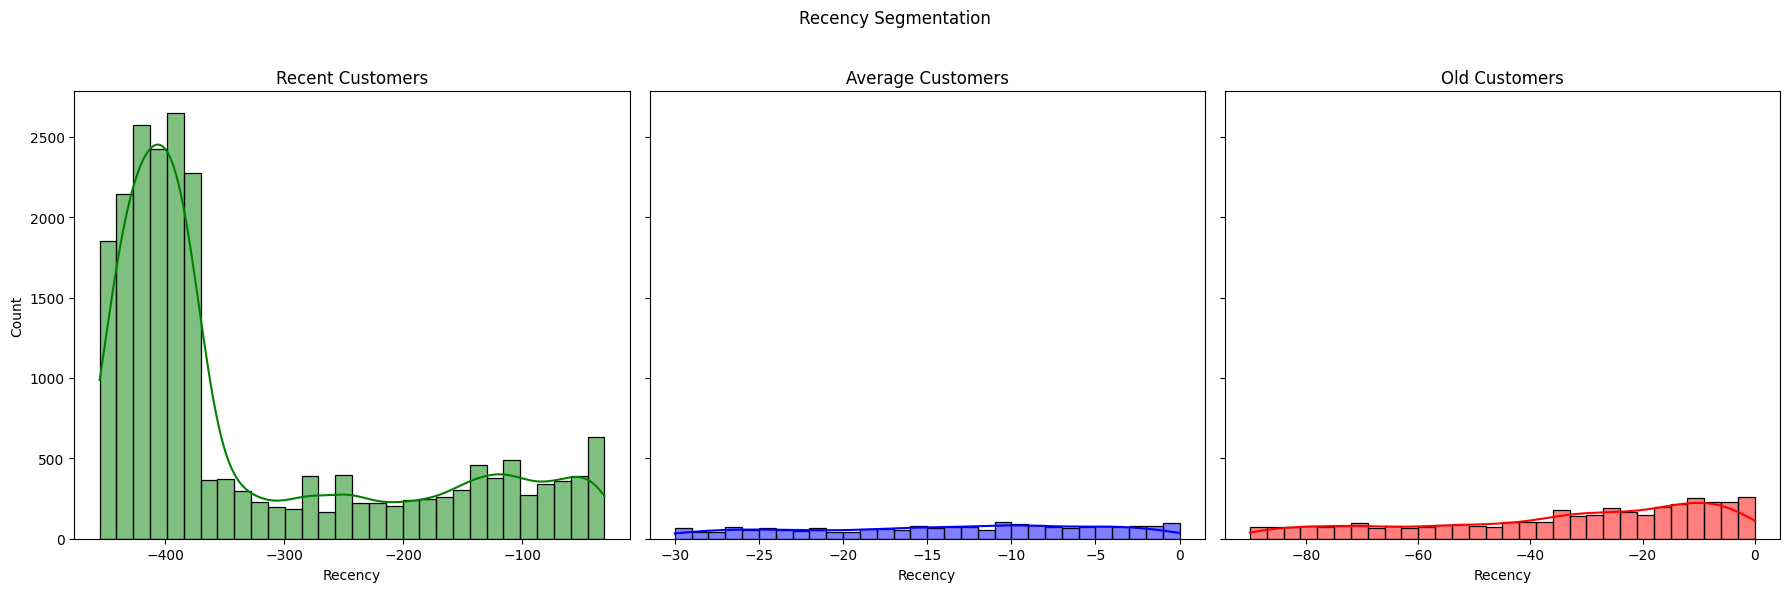

In [7]:
# Recency Segmentation
fig, ax = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
fig.suptitle('Recency Segmentation')

sns.histplot(recent_customers['recency'], bins=30, kde=True, color='green', ax=ax[0])
ax[0].set_title('Recent Customers')
ax[0].set_xlabel('Recency')

sns.histplot(average_customers['recency'], bins=30, kde=True, color='blue', ax=ax[1])
ax[1].set_title('Average Customers')
ax[1].set_xlabel('Recency')

sns.histplot(old_customers['recency'], bins=30, kde=True, color='red', ax=ax[2])
ax[2].set_title('Old Customers')
ax[2].set_xlabel('Recency')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

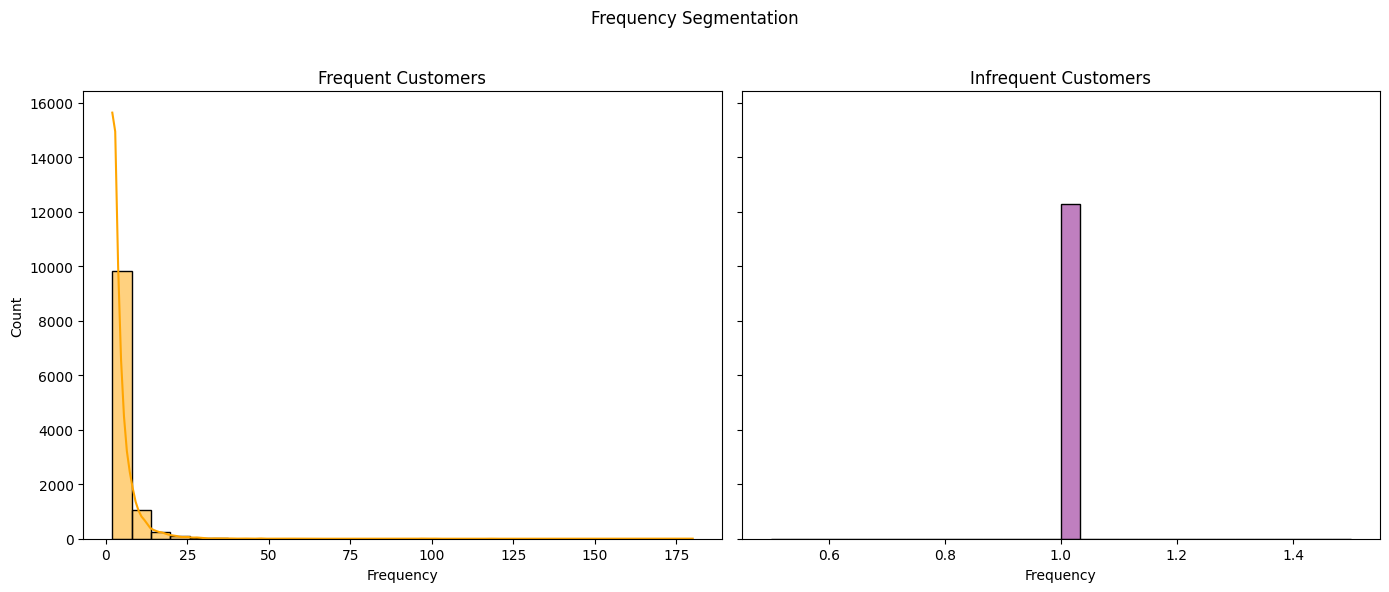

In [8]:
# Frequency Segmentation
fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
fig.suptitle('Frequency Segmentation')

sns.histplot(frequent_customers['frequency'], bins=30, kde=True, color='orange', ax=ax[0])
ax[0].set_title('Frequent Customers')
ax[0].set_xlabel('Frequency')

sns.histplot(infrequent_customers['frequency'], bins=30, kde=True, color='purple', ax=ax[1])
ax[1].set_title('Infrequent Customers')
ax[1].set_xlabel('Frequency')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

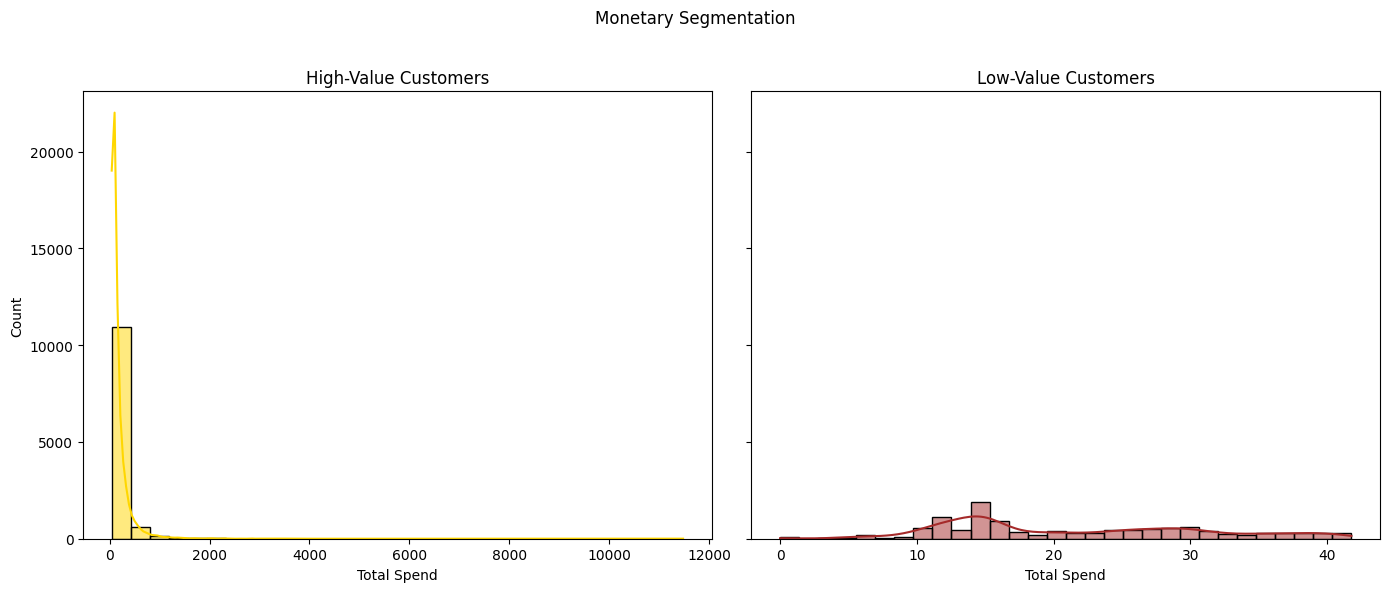

In [9]:
# Monetary Segmentation
fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
fig.suptitle('Monetary Segmentation')

sns.histplot(high_value_customers['price_sum'], bins=30, kde=True, color='gold', ax=ax[0])
ax[0].set_title('High-Value Customers')
ax[0].set_xlabel('Total Spend')

sns.histplot(low_value_customers['price_sum'], bins=30, kde=True, color='brown', ax=ax[1])
ax[1].set_title('Low-Value Customers')
ax[1].set_xlabel('Total Spend')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [13]:
# Combined Segmentation
high_value_frequent_recent_customers = predictions_df[
    (predictions_df['price_sum'] > predictions_df['price_sum'].median()) &
    (predictions_df['frequency'] > predictions_df['frequency'].median()) &
    (predictions_df['recency'] < 30)
]

print(f"Number of high-value, frequent, and recent purchases: {high_value_frequent_recent_customers.shape[0]}")

Number of high-value, frequent, and recent purchases: 9357


#### Visualize Recency Segmentation

/tmp/ipykernel_697610/1927084951.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='spend_90_flag', y='recency', data=predictions_df, palette='coolwarm')


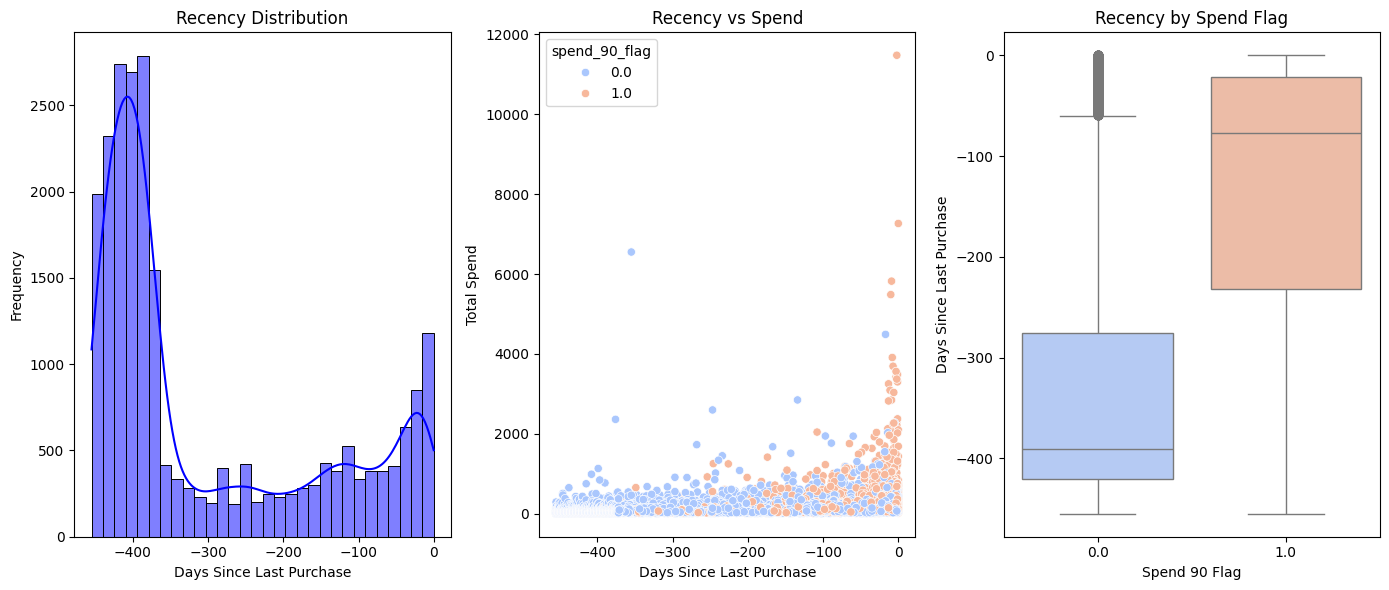

In [47]:
# Set up the matplotlib figure
plt.figure(figsize=(14, 6))

# Plot Recency histogram
plt.subplot(1, 3, 1)
sns.histplot(predictions_df['recency'], bins=30, kde=True, color='blue')
plt.title('Recency Distribution')
plt.xlabel('Days Since Last Purchase')
plt.ylabel('Frequency')

# Plot Recency scatter plot
plt.subplot(1, 3, 2)
sns.scatterplot(data=predictions_df, x='recency', y='price_sum', hue='spend_90_flag', palette='coolwarm')
plt.title('Recency vs Spend')
plt.xlabel('Days Since Last Purchase')
plt.ylabel('Total Spend')

# Plot Recency box plot
plt.subplot(1, 3, 3)
sns.boxplot(x='spend_90_flag', y='recency', data=predictions_df, palette='coolwarm')
plt.title('Recency by Spend Flag')
plt.xlabel('Spend 90 Flag')
plt.ylabel('Days Since Last Purchase')

plt.tight_layout()
plt.show()


 #### Visualize Frequency Segmentation

/tmp/ipykernel_697610/1848799178.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='spend_90_flag', y='frequency', data=predictions_df, palette='coolwarm')


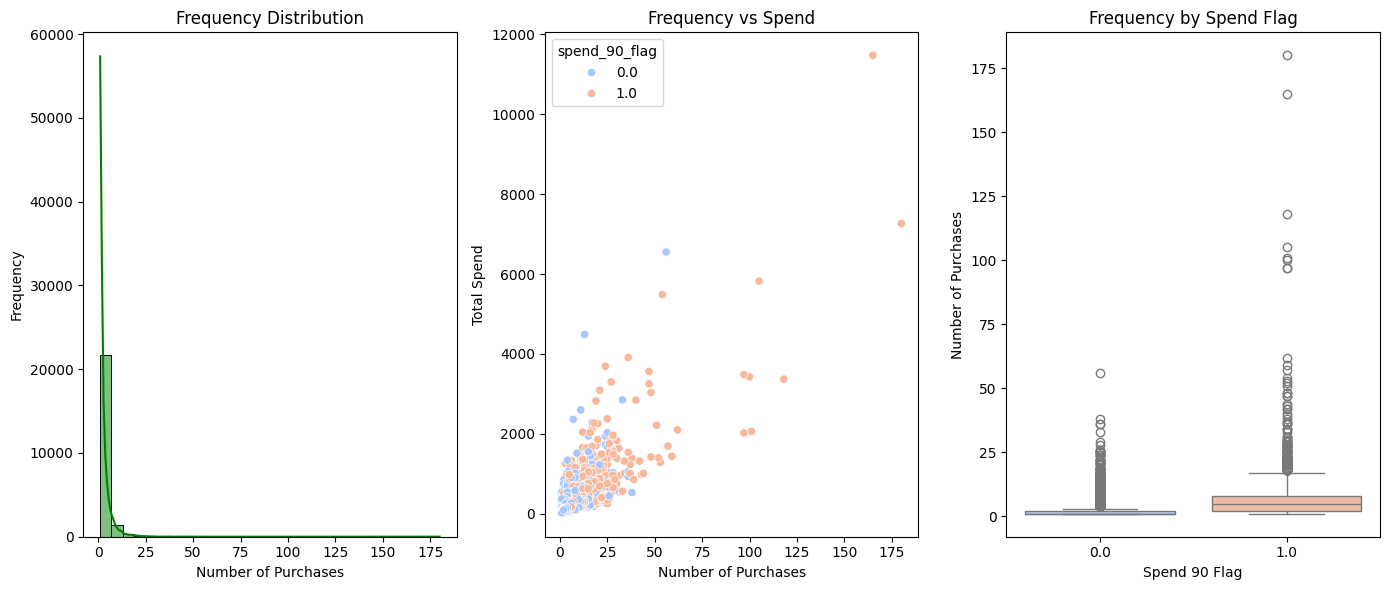

In [48]:
# Set up the matplotlib figure
plt.figure(figsize=(14, 6))

# Plot Frequency histogram
plt.subplot(1, 3, 1)
sns.histplot(predictions_df['frequency'], bins=30, kde=True, color='green')
plt.title('Frequency Distribution')
plt.xlabel('Number of Purchases')
plt.ylabel('Frequency')

# Plot Frequency scatter plot
plt.subplot(1, 3, 2)
sns.scatterplot(data=predictions_df, x='frequency', y='price_sum', hue='spend_90_flag', palette='coolwarm')
plt.title('Frequency vs Spend')
plt.xlabel('Number of Purchases')
plt.ylabel('Total Spend')

# Plot Frequency box plot
plt.subplot(1, 3, 3)
sns.boxplot(x='spend_90_flag', y='frequency', data=predictions_df, palette='coolwarm')
plt.title('Frequency by Spend Flag')
plt.xlabel('Spend 90 Flag')
plt.ylabel('Number of Purchases')

plt.tight_layout()
plt.show()

#### Visualize Monetary Segmentation

/tmp/ipykernel_697610/2471236298.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='spend_90_flag', y='price_sum', data=predictions_df, palette='coolwarm')


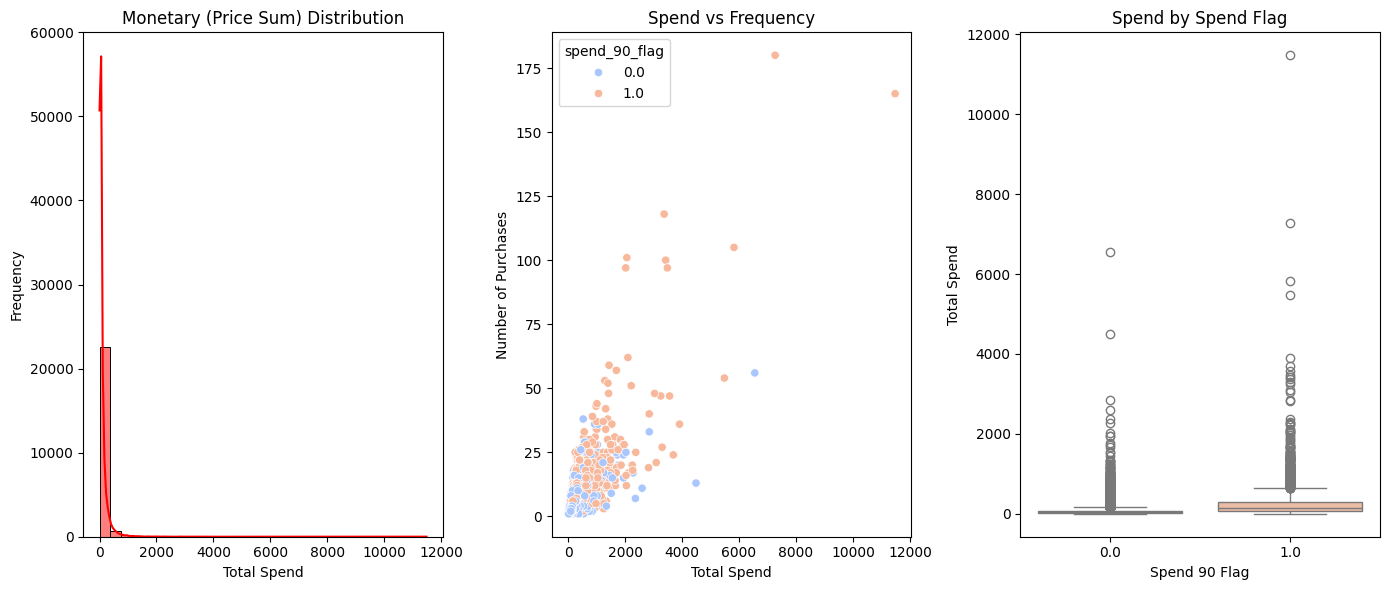

In [49]:
# Set up the matplotlib figure
plt.figure(figsize=(14, 6))

# Plot Monetary histogram
plt.subplot(1, 3, 1)
sns.histplot(predictions_df['price_sum'], bins=30, kde=True, color='red')
plt.title('Monetary (Price Sum) Distribution')
plt.xlabel('Total Spend')
plt.ylabel('Frequency')

# Plot Monetary scatter plot
plt.subplot(1, 3, 2)
sns.scatterplot(data=predictions_df, x='price_sum', y='frequency', hue='spend_90_flag', palette='coolwarm')
plt.title('Spend vs Frequency')
plt.xlabel('Total Spend')
plt.ylabel('Number of Purchases')

# Plot Monetary box plot
plt.subplot(1, 3, 3)
sns.boxplot(x='spend_90_flag', y='price_sum', data=predictions_df, palette='coolwarm')
plt.title('Spend by Spend Flag')
plt.xlabel('Spend 90 Flag')
plt.ylabel('Total Spend')

plt.tight_layout()
plt.show()

### Customer Segmentation

In [50]:
# High Probability & High Spend
high_prob_high_spend = predictions_df[
    (predictions_df['pred_prob'] > 0.7) & 
    (predictions_df['pred_spend'] > predictions_df['pred_spend'].median())
]

# Low Probability & Low Spend
low_prob_low_spend = predictions_df[
    (predictions_df['pred_prob'] <= 0.7) & 
    (predictions_df['pred_spend'] <= predictions_df['pred_spend'].median())
]

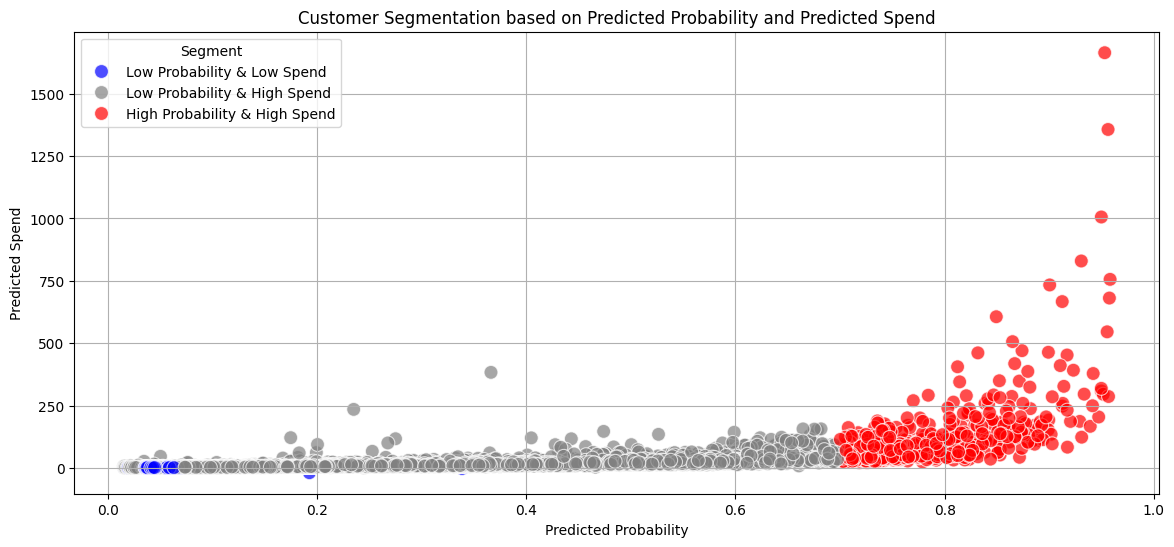

In [62]:
# Define threshold values for high and low segmentation
prob_threshold = 0.7
spend_threshold = predictions_df['pred_spend'].median()

# Define segments
predictions_df['Segment'] = 'Low Probability & Low Spend'
predictions_df.loc[(predictions_df['pred_prob'] > prob_threshold) & (predictions_df['pred_spend'] > spend_threshold), 'Segment'] = 'High Probability & High Spend'
predictions_df.loc[(predictions_df['pred_prob'] > prob_threshold) & (predictions_df['pred_spend'] <= spend_threshold), 'Segment'] = 'High Probability & Low Spend'
predictions_df.loc[(predictions_df['pred_prob'] <= prob_threshold) & (predictions_df['pred_spend'] > spend_threshold), 'Segment'] = 'Low Probability & High Spend'

# Define color mapping for each segment
color_mapping = {
    'Low Probability & Low Spend': 'blue',
    'Low Probability & High Spend': 'grey',
    'High Probability & High Spend': 'red',
    'High Probability & Low Spend': 'green'
}

# Set up the matplotlib figure
plt.figure(figsize=(14, 6))

# Scatter plot for customer segmentation with transparency
sns.scatterplot(data=predictions_df, x='pred_prob', y='pred_spend', hue='Segment', palette=color_mapping, s=100, alpha=0.7)
plt.title('Customer Segmentation based on Predicted Probability and Predicted Spend')
plt.xlabel('Predicted Probability')
plt.ylabel('Predicted Spend')
plt.legend(title='Segment')
plt.grid(True)
plt.show()

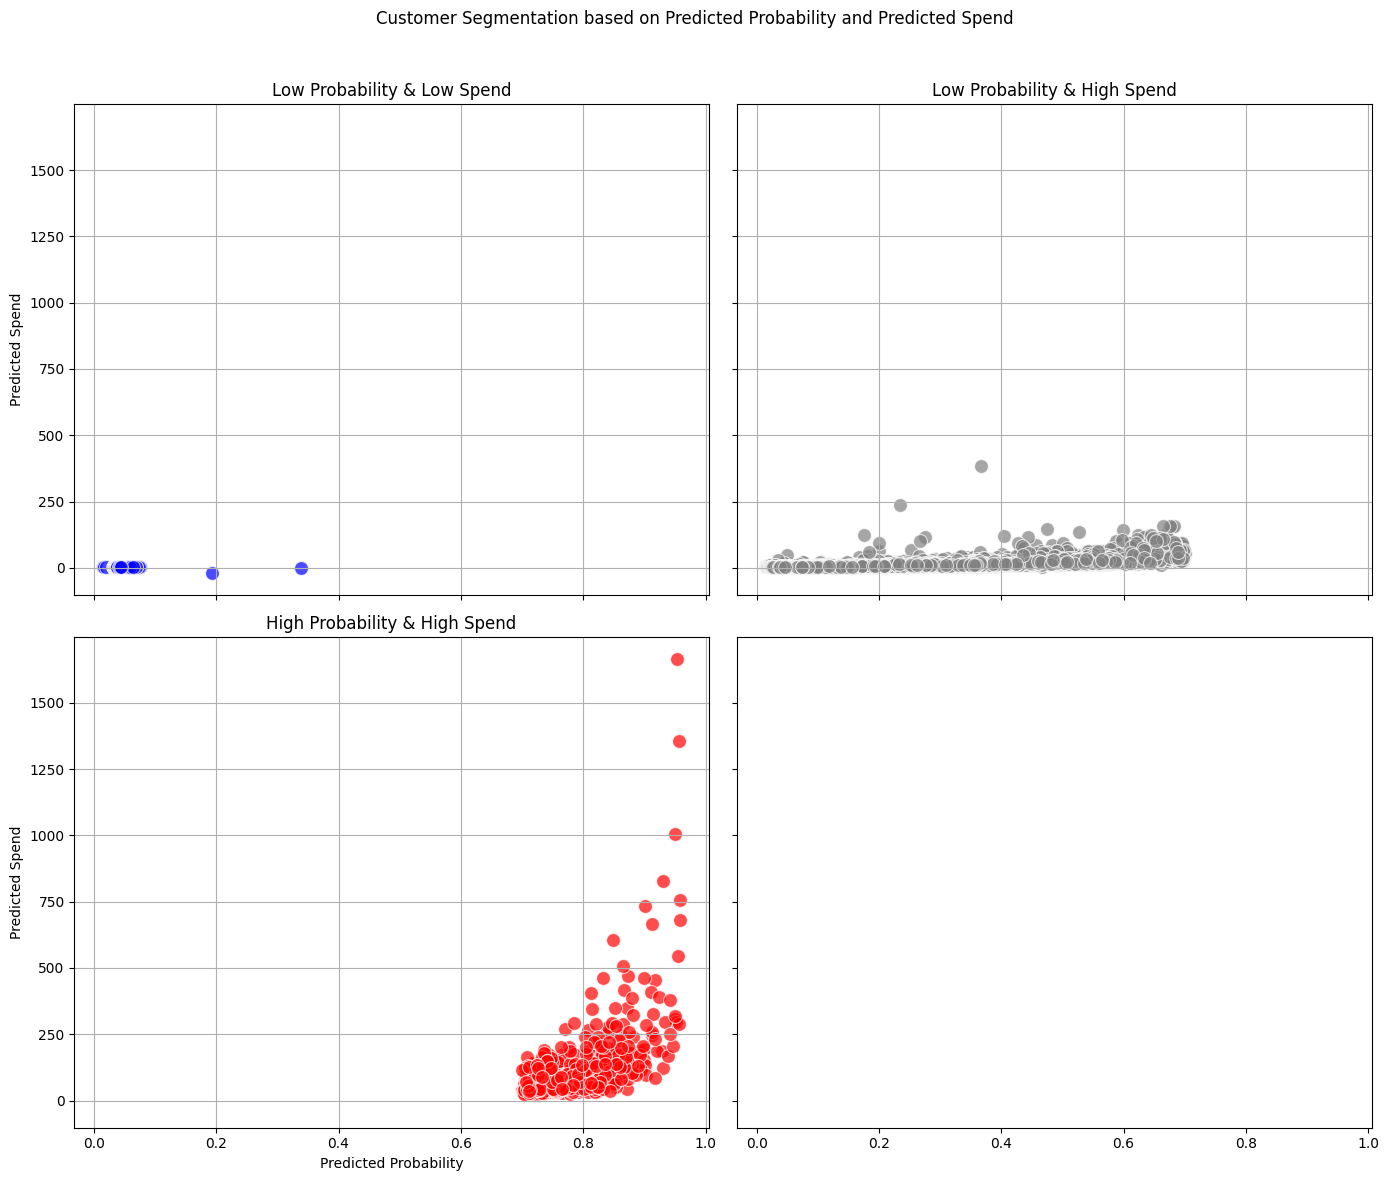

In [60]:
# Define threshold values for high and low segmentation
prob_threshold = 0.7
spend_threshold = predictions_df['pred_spend'].median()

# Define segments
predictions_df['Segment'] = 'Low Probability & Low Spend'
predictions_df.loc[(predictions_df['pred_prob'] > prob_threshold) & (predictions_df['pred_spend'] > spend_threshold), 'Segment'] = 'High Probability & High Spend'
predictions_df.loc[(predictions_df['pred_prob'] > prob_threshold) & (predictions_df['pred_spend'] <= spend_threshold), 'Segment'] = 'High Probability & Low Spend'
predictions_df.loc[(predictions_df['pred_prob'] <= prob_threshold) & (predictions_df['pred_spend'] > spend_threshold), 'Segment'] = 'Low Probability & High Spend'

# Define color mapping for each segment
color_mapping = {
    'Low Probability & Low Spend': 'blue',
    'Low Probability & High Spend': 'grey',
    'High Probability & High Spend': 'red',
    'High Probability & Low Spend': 'green'  # Assuming a default color for this segment
}

# Separate scatter plots for each segment
fig, axes = plt.subplots(2, 2, figsize=(14, 12), sharex=True, sharey=True)
fig.suptitle('Customer Segmentation based on Predicted Probability and Predicted Spend')

for ax, segment in zip(axes.flatten(), segments):
    sns.scatterplot(
        data=predictions_df[predictions_df['Segment'] == segment],
        x='pred_prob', 
        y='pred_spend',
        color=color_mapping.get(segment, 'black'),  # Default to black if the segment is not found in the mapping
        s=100, 
        alpha=0.7, 
        ax=ax
    )
    ax.set_title(segment)
    ax.set_xlabel('Predicted Probability')
    ax.set_ylabel('Predicted Spend')
    ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### What percent of our current customer base made a purchase in the last 90 days?

In [100]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23570 entries, 1 to 23570
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   recency         23570 non-null  int64  
 1   frequency       23570 non-null  int64  
 2   price_sum       23570 non-null  float64
 3   price_mean      23570 non-null  float64
 4   spend_90_total  23570 non-null  float64
 5   spend_90_flag   23570 non-null  float64
dtypes: float64(4), int64(2)
memory usage: 1.3 MB


In [99]:
features_df.spend_90_flag.value_counts()

spend_90_flag
0.0    20269
1.0     3301
Name: count, dtype: int64

In [102]:
percent = round((3301/23570)*100,2)

print(f'{percent}% of our current customers made a purchase in the last 90 days')

14.01% of our current customers made a purchase in the last 90 days


### Which customers have the highest spend probability in the next 90 days?

In [52]:
predictions_df.sort_values('pred_prob', ascending=False).head(10)

,pred_prob,pred_spend,recency,frequency,price_sum,price_mean,spend_90_total,spend_90_flag,Segment
498,0.958165,756.116807,-3,100,3427.55,34.275500,951.00,1.0,High Probability & High Spend
3048,0.957513,681.253668,-1,97,3484.03,35.917835,778.82,1.0,High Probability & High Spend
10078,0.956696,286.959958,0,62,2100.38,33.877097,100.43,1.0,High Probability & High Spend
14047,0.956217,1356.334753,0,180,7267.15,40.373056,1709.18,1.0,High Probability & High Spend
22060,0.955357,545.950024,-2,118,3371.80,28.574576,577.10,1.0,High Probability & High Spend
7591,0.953021,1663.674707,-2,165,11478.02,69.563758,2512.91,1.0,High Probability & High Spend
2483,0.951641,295.990932,0,59,1438.93,24.388644,345.43,1.0,High Probability & High Spend
7982,0.949804,1005.800879,-9,105,5824.14,55.468000,1148.93,1.0,High Probability & High Spend
19596,0.949779,319.653983,-1,97,2023.00,20.855670,334.57,1.0,High Probability & High Spend
709,0.949731,308.909994,-2,51,2216.45,43.459804,285.85,1.0,High Probability & High Spend


### Which customers have recently purchases but are unlikely to buy?

* Incentivize actions to increase probability.
* Provide discounts, encourage referring a friend, nurture by letting them know what's coming.

In [53]:
# customers that purchased in the last year but are unlikely to make another purchase
drop_out = predictions_df[
    (predictions_df['recency'] > -90) & 
    (predictions_df['pred_prob'] < 0.20)
].sort_values('pred_prob', ascending=False).head(10)

# Display the filtered DataFrame
drop_out

,pred_prob,pred_spend,recency,frequency,price_sum,price_mean,spend_90_total,spend_90_flag,Segment
3928,0.199928,11.248081,-8,2,229.17,114.585000,0.0,0.0,Low Probability & High Spend
7489,0.199864,5.902758,-62,3,23.35,7.783333,0.0,0.0,Low Probability & High Spend
6411,0.199612,8.767751,-57,2,249.04,124.520000,0.0,0.0,Low Probability & High Spend
8035,0.199396,8.355247,-4,2,51.48,25.740000,0.0,0.0,Low Probability & High Spend
23290,0.199286,6.256657,-69,2,59.48,29.740000,0.0,0.0,Low Probability & High Spend
3614,0.199067,7.515486,-10,2,45.96,22.980000,0.0,0.0,Low Probability & High Spend
2454,0.198555,7.904704,-4,2,39.94,19.970000,0.0,0.0,Low Probability & High Spend
13556,0.198441,5.395245,-58,2,38.57,19.285000,0.0,0.0,Low Probability & High Spend
20924,0.198344,5.783857,-58,2,41.80,20.900000,0.0,0.0,Low Probability & High Spend
7687,0.198020,8.515495,-80,2,141.83,70.915000,0.0,0.0,Low Probability & High Spend


### Missed opportunities: spenders that could be unlocked

* Send bundle offers encourage volume purchases
* Focus on missed opportunities

In [54]:
# Did the model predict any large spending that did not occur?
# Filtered by did not spend but had a high probability of spend and recency was within the last 90 days.
missed_opportunities = predictions_df[
    (predictions_df['spend_90_total'] == 0.0) & 
    (predictions_df['recency'] >= -90)
].sort_values('pred_prob', ascending=False).head(10)

# Display the filtered DataFrame
missed_opportunities

,pred_prob,pred_spend,recency,frequency,price_sum,price_mean,spend_90_total,spend_90_flag,Segment
4158,0.880867,100.083409,-4,36,931.68,25.880000,0.0,0.0,High Probability & High Spend
5054,0.840880,126.974952,-8,20,797.11,39.855500,0.0,0.0,High Probability & High Spend
7322,0.840107,125.181479,-10,22,827.28,37.603636,0.0,0.0,High Probability & High Spend
21684,0.829403,206.673739,-14,25,2031.06,81.242400,0.0,0.0,High Probability & High Spend
19946,0.826768,71.433366,-8,19,539.11,28.374211,0.0,0.0,High Probability & High Spend
13966,0.824169,88.953264,-6,17,586.78,34.516471,0.0,0.0,High Probability & High Spend
3887,0.823418,35.306259,-14,25,324.53,12.981200,0.0,0.0,High Probability & High Spend
15079,0.819383,42.657021,-6,19,367.58,19.346316,0.0,0.0,High Probability & High Spend
15099,0.818553,79.728208,-16,21,483.12,23.005714,0.0,0.0,High Probability & High Spend
17522,0.817965,219.649366,-5,17,2280.08,134.122353,0.0,0.0,High Probability & High Spend


In [55]:
# Show predictions that are larger than actual spend
# Filtered by pred spend is larger than actual, recency is last 90 days, and they actually made a purchase
under_spending = predictions_df[
    (predictions_df['pred_spend'] > predictions_df['spend_90_total']) & 
    (predictions_df['recency'] >= -90) & 
    (predictions_df['spend_90_flag'] == 1.0)
].sort_values('pred_spend', ascending=False).head(10)

# Display the filtered DataFrame
under_spending

,pred_prob,pred_spend,recency,frequency,price_sum,price_mean,spend_90_total,spend_90_flag,Segment
2663,0.873993,470.526511,-7,24,3694.52,153.938333,405.75,1.0,High Probability & High Spend
13166,0.942000,379.059347,-3,47,3563.95,75.828723,334.75,1.0,High Probability & High Spend
22491,0.852323,350.044503,-6,18,2271.27,126.181667,117.45,1.0,High Probability & High Spend
709,0.949731,308.909994,-2,51,2216.45,43.459804,285.85,1.0,High Probability & High Spend
10078,0.956696,286.959958,0,62,2100.38,33.877097,100.43,1.0,High Probability & High Spend
20110,0.902878,285.779539,-6,36,1538.49,42.735833,209.09,1.0,High Probability & High Spend
8327,0.841322,277.873072,-10,18,1392.46,77.358889,68.48,1.0,High Probability & High Spend
1847,0.808370,264.523190,-35,31,1639.32,52.881290,227.36,1.0,High Probability & High Spend
18174,0.912955,259.506173,-3,28,1493.42,53.336429,117.93,1.0,High Probability & High Spend
9885,0.874833,259.505342,-3,19,1704.08,89.688421,146.42,1.0,High Probability & High Spend
